# Volatility Forecasting 

In [1]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
random_state = 42
np.random.seed(42)
tf.random.set_seed(42)

svr_lin = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [2]:
stocks = '^GSPC'
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2024, 8, 23)
s_p500 = yf.download(stocks, start, end, interval='1d')
ret = 100*((s_p500['Adj Close']).pct_change()[1:])
realized_vol = ret.rolling(5).std()

[*********************100%***********************]  1 of 1 completed


In [3]:
ret = 100*((s_p500['Adj Close']).pct_change()[1:])
realized_vol = ret.rolling(5).std()

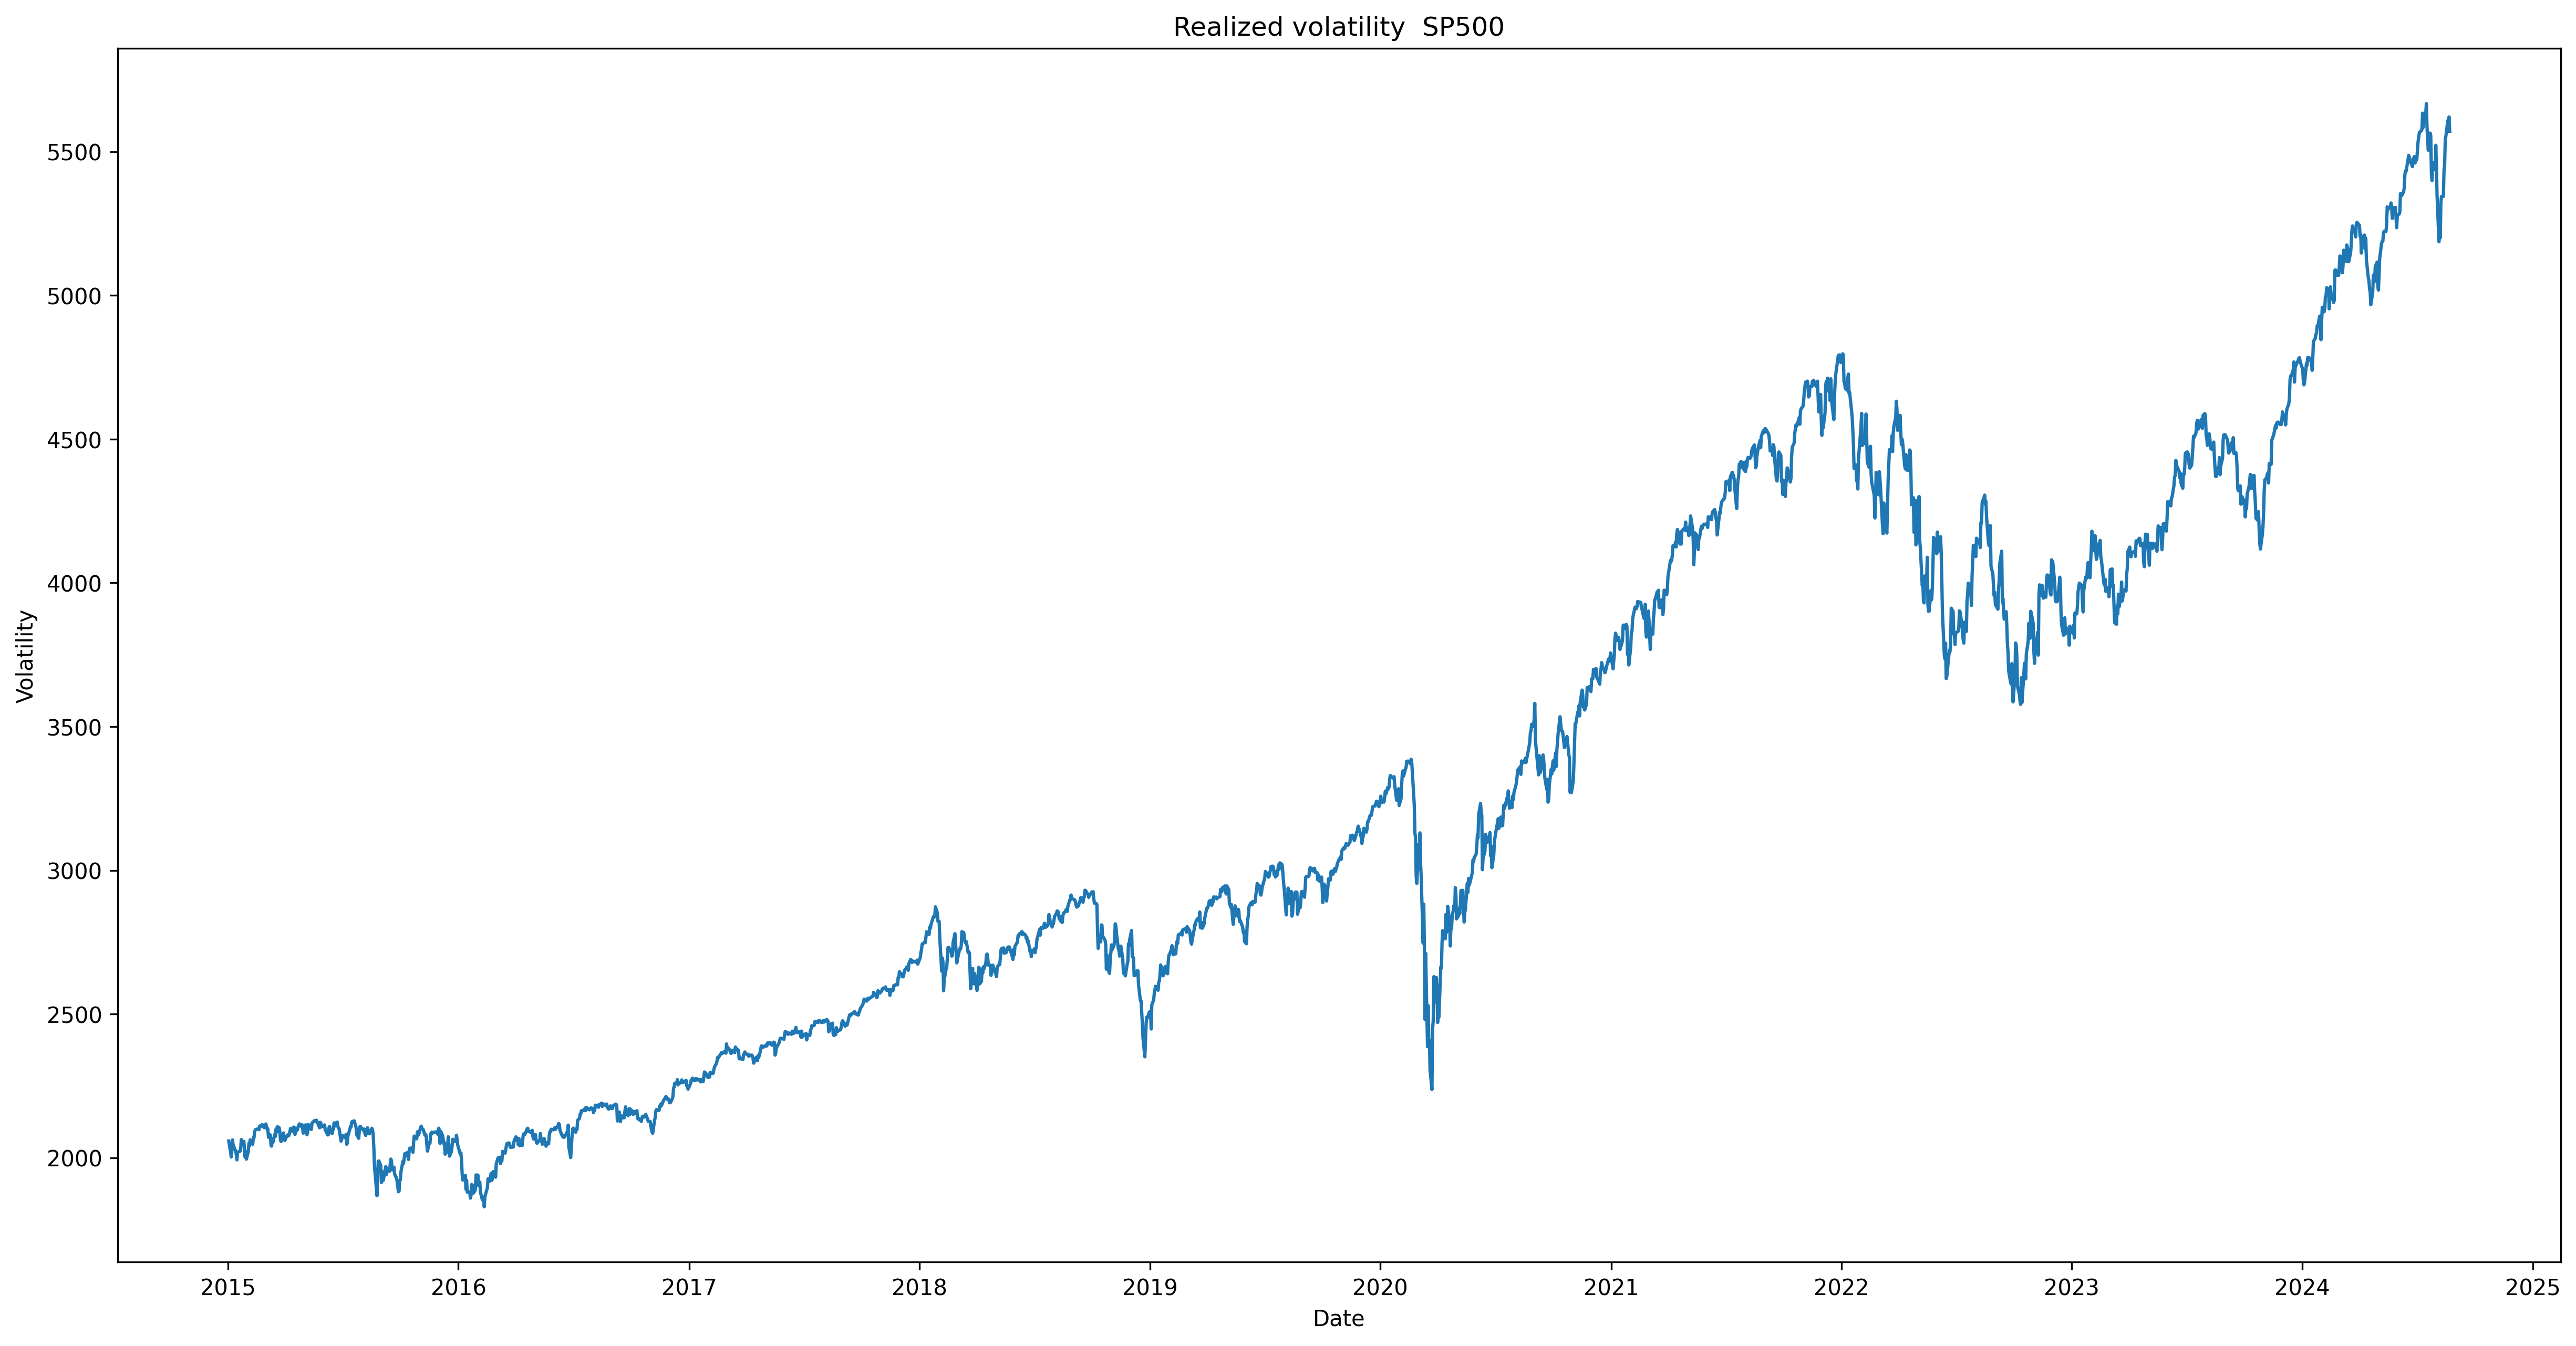

In [4]:
plt.figure(figsize=(20, 10))
plt.plot(s_p500['Adj Close'].index, s_p500['Adj Close'])
plt.title('Realized volatility  SP500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

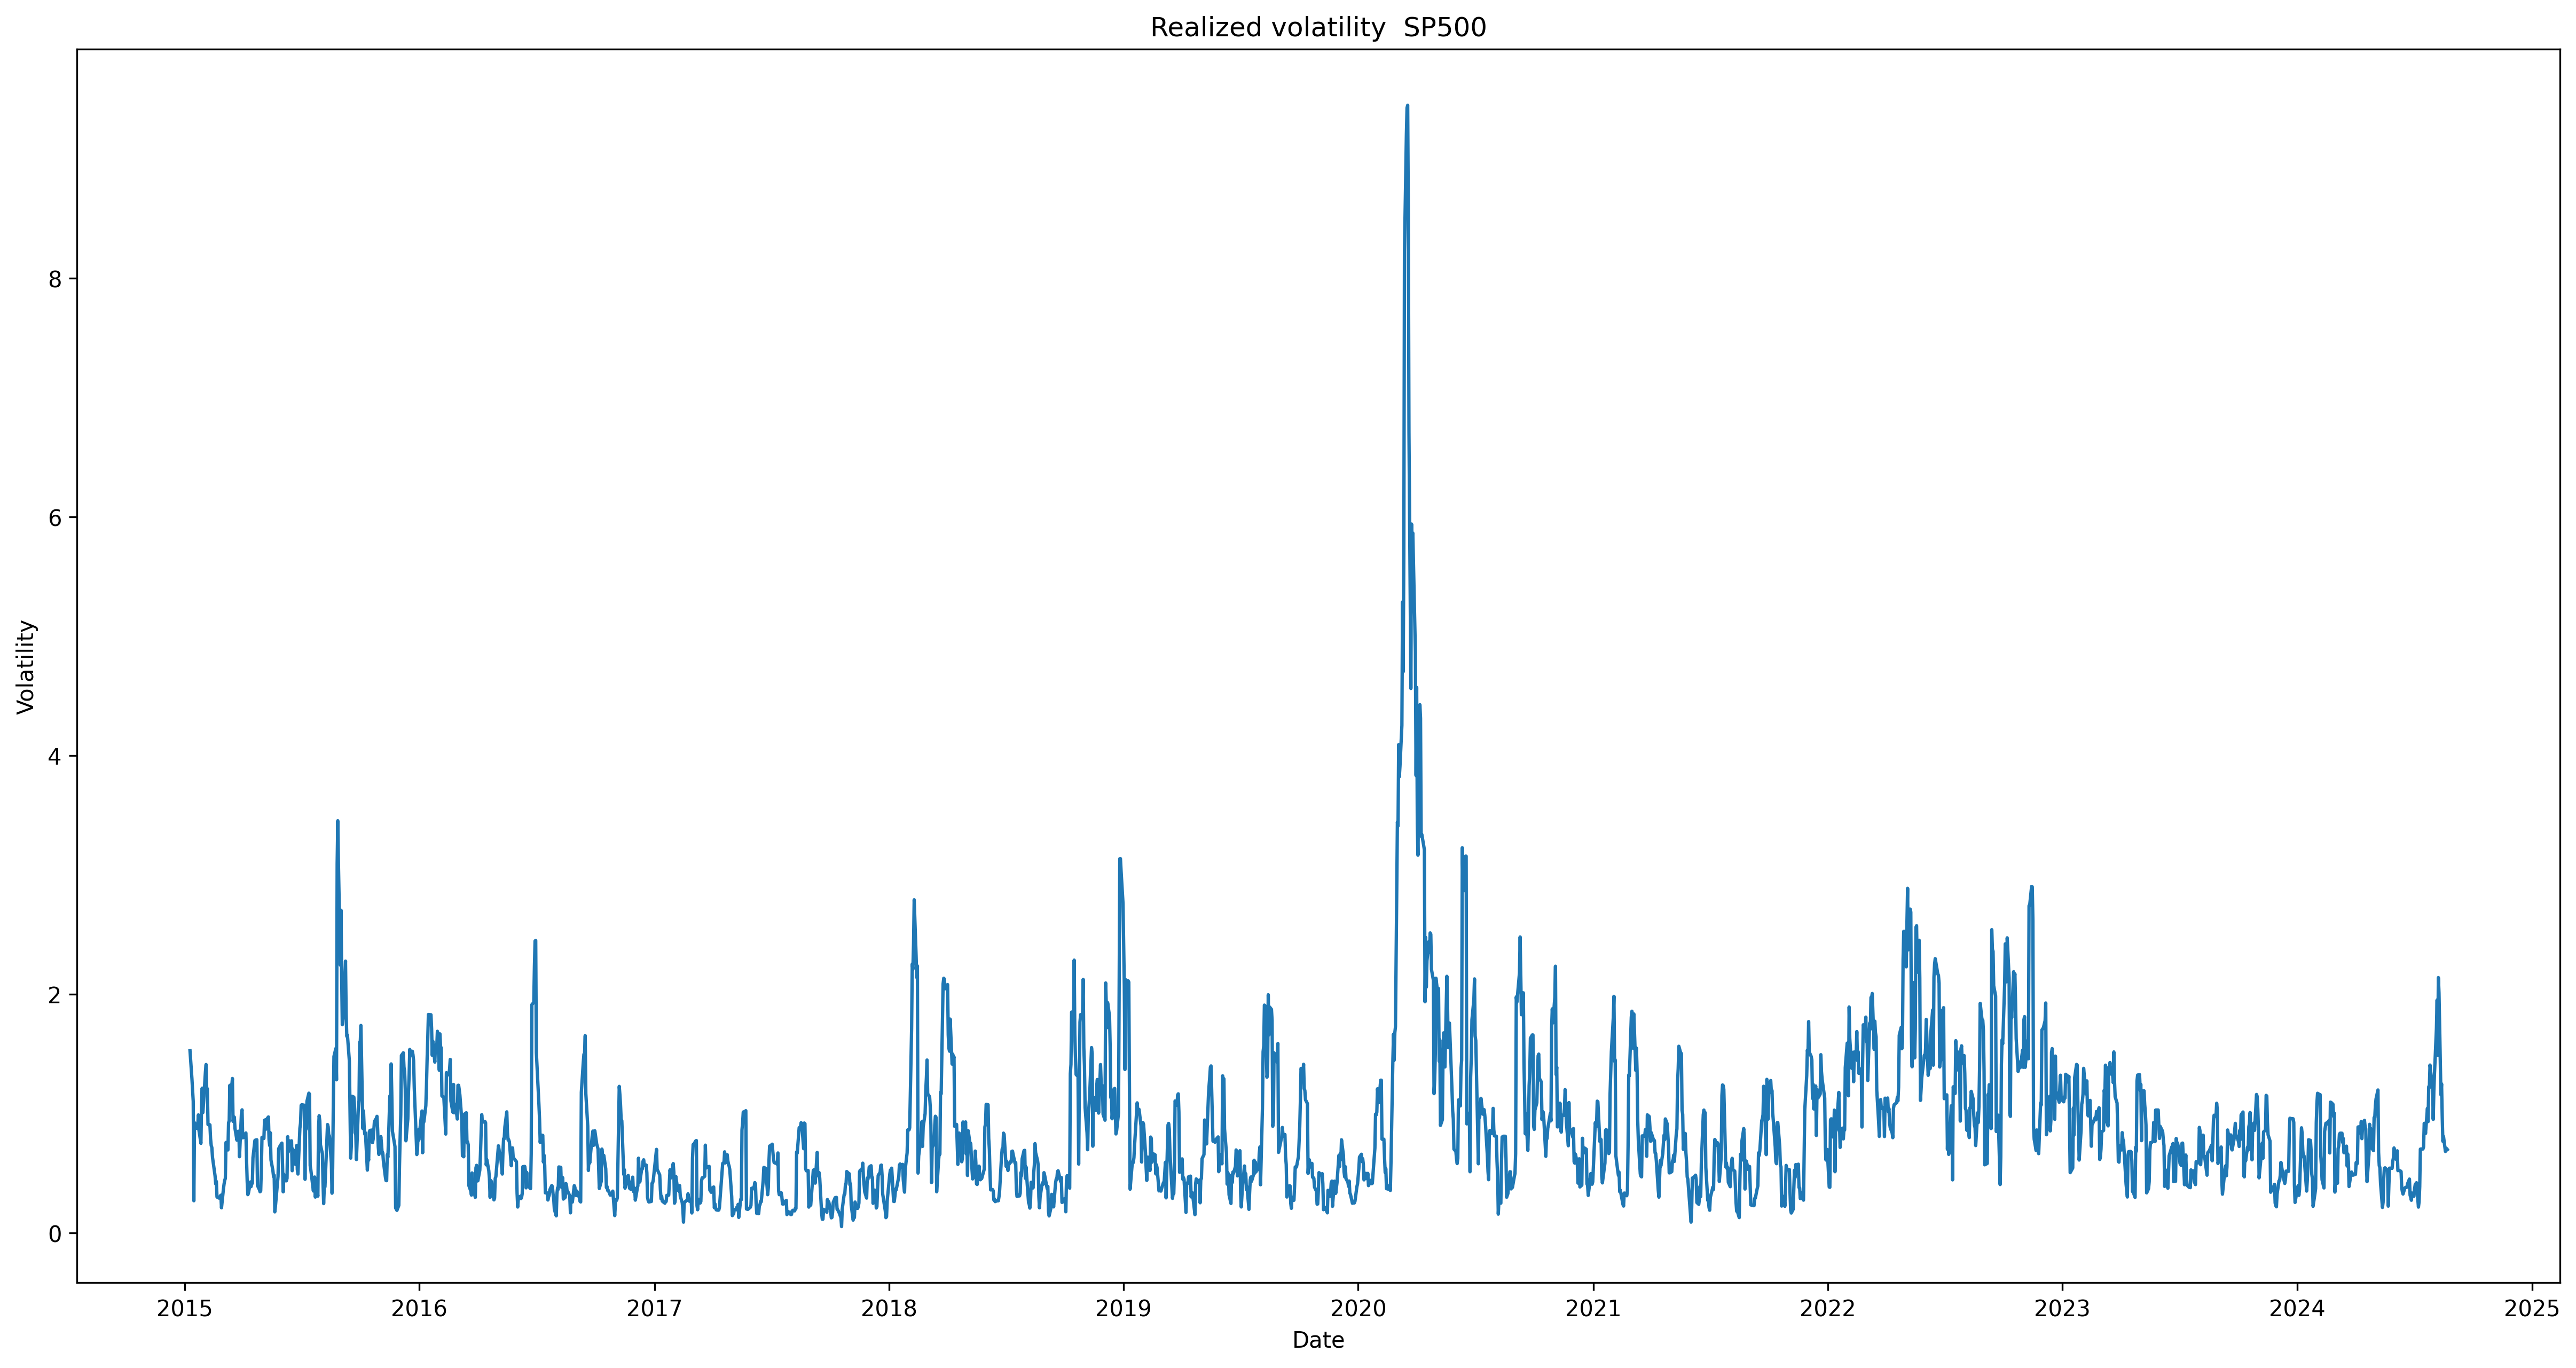

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol.index, realized_vol)
plt.title('Realized volatility  SP500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

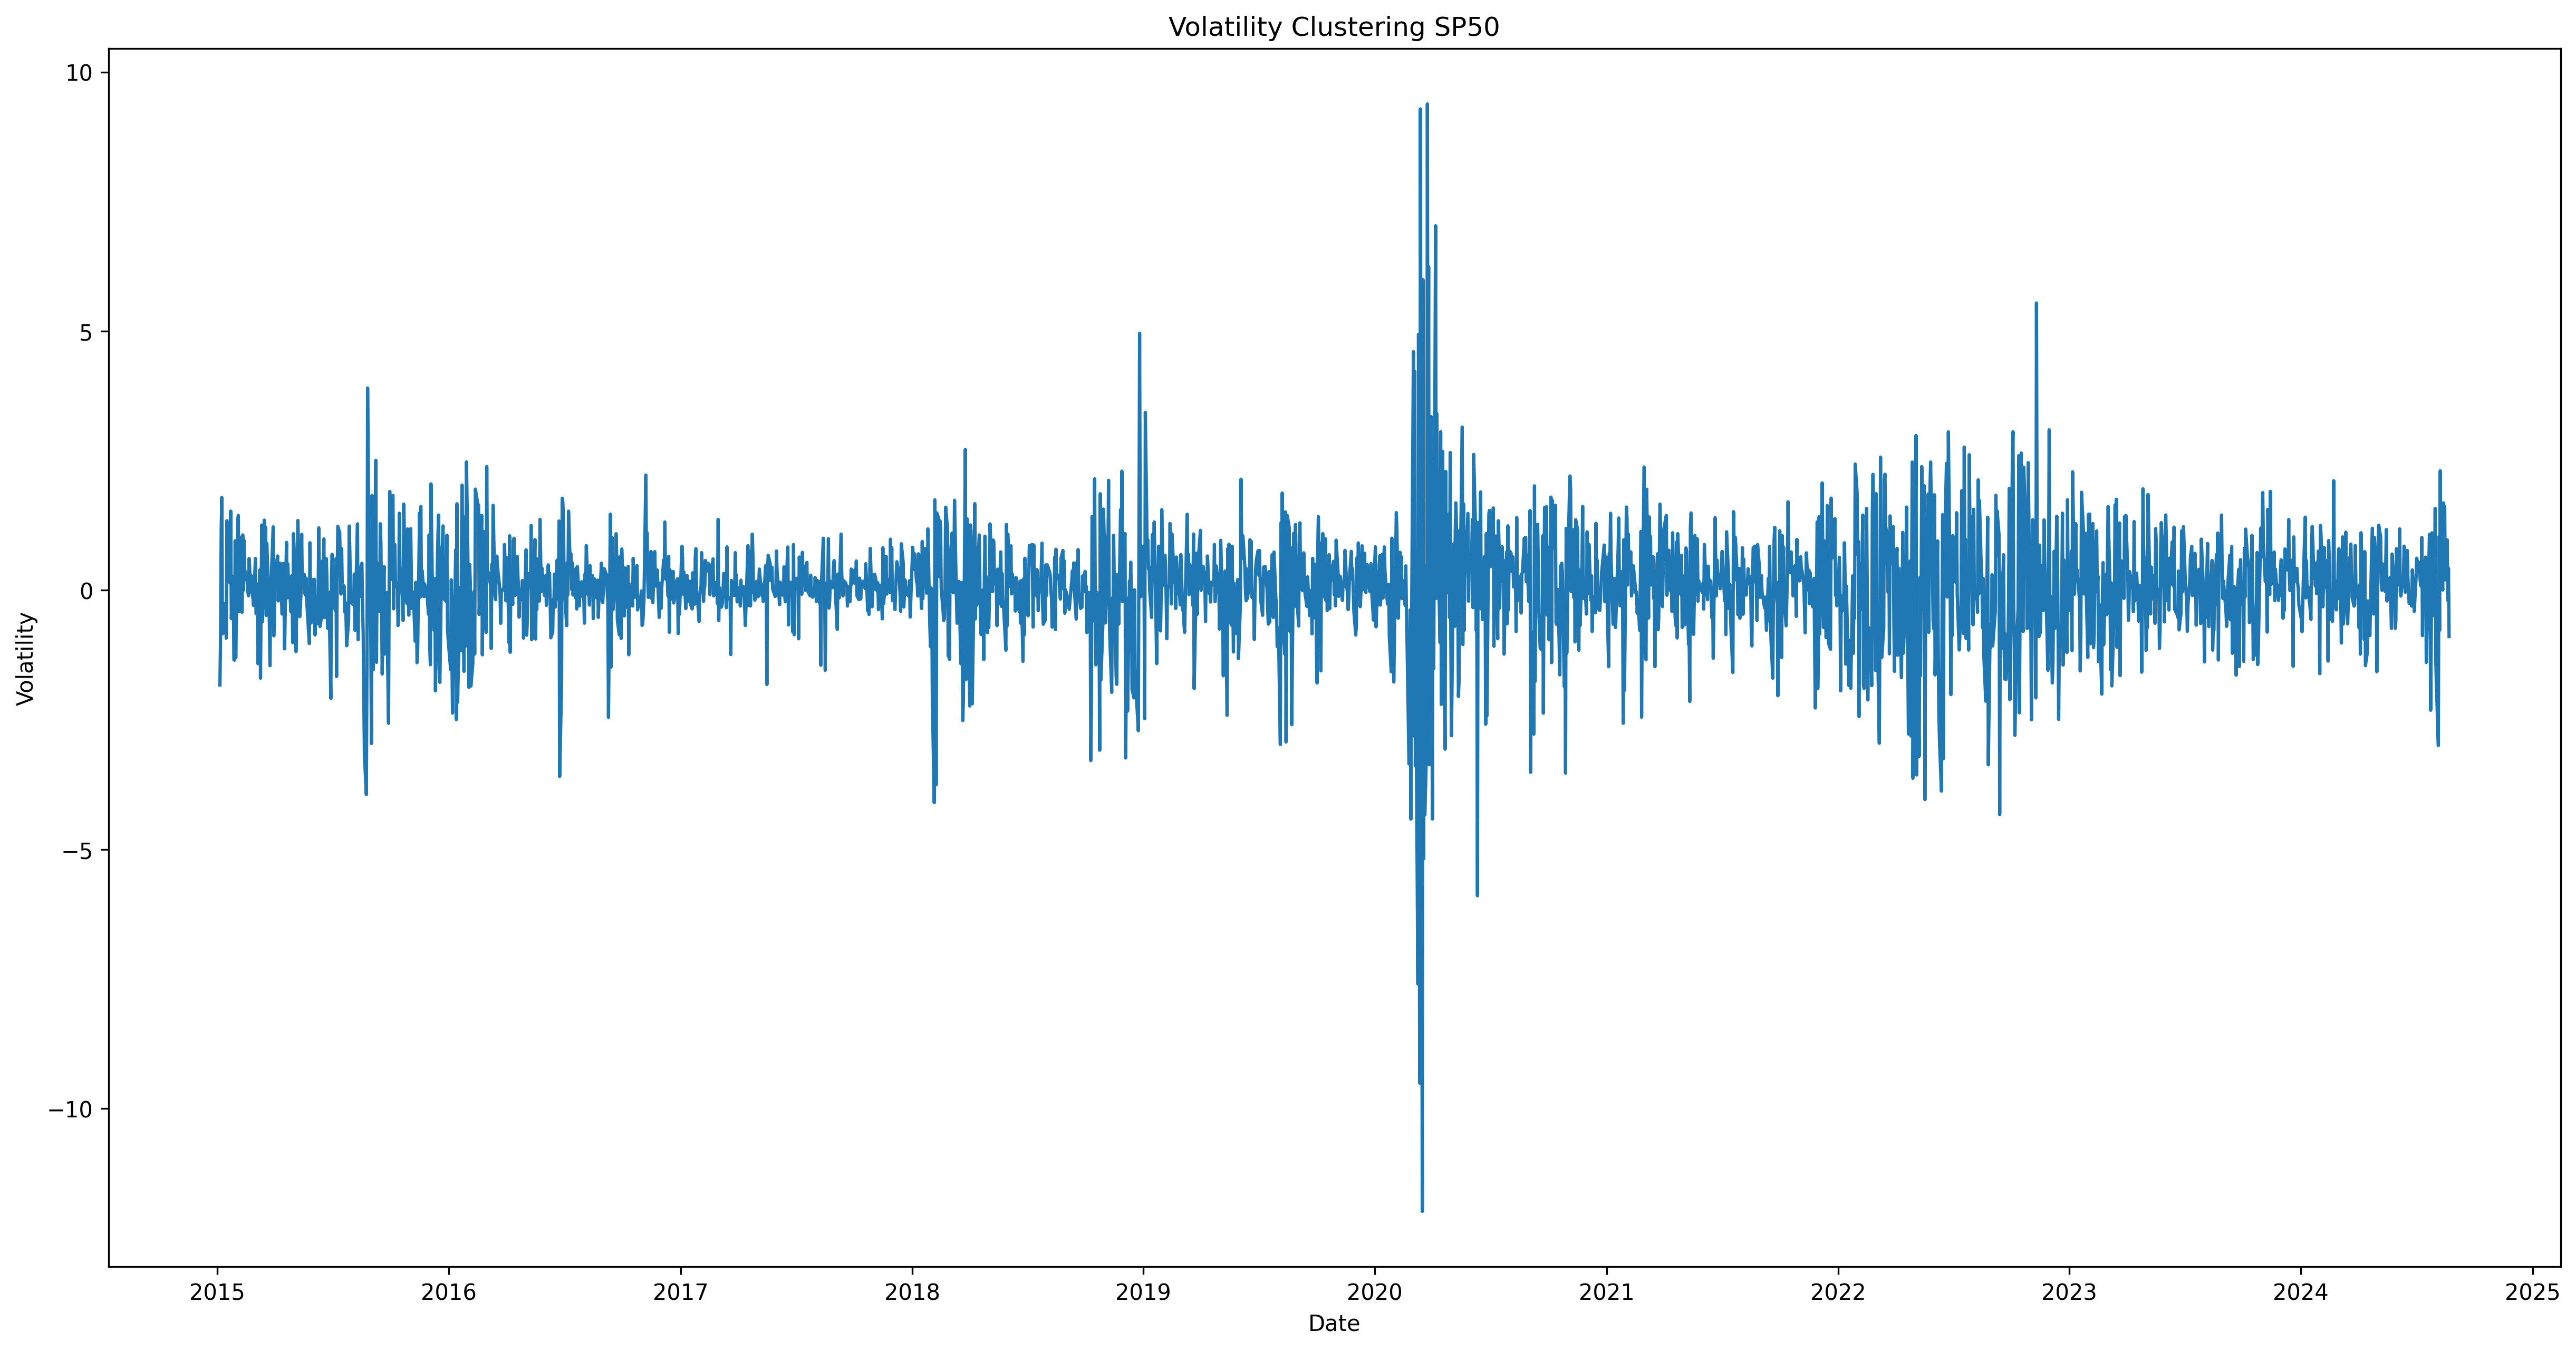

In [6]:
plt.figure(figsize=(20, 10))
plt.plot(ret.index, ret)
plt.title('Volatility Clustering SP500 Return')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

## Volatility Modeling 

### ARCH

In [7]:
n = 252
split_date = ret.iloc[-n:].index
retv = ret.values

In [8]:
bic_arch = []

for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
        .fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p

arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
    .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3177.37
Distribution:                  Normal   AIC:                           6364.74
Method:            Maximum Likelihood   BIC:                           6393.70
                                        No. Observations:                 2425
Date:                Wed, Sep 25 2024   Df Residuals:                     2425
Time:                        13:32:20   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.2762  3.033e-02      9.107  8.496e-20   [  0.21

In [9]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                        np.sqrt(forecast_arch
                        .variance.iloc[-len(split_date):]
                        / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.0808


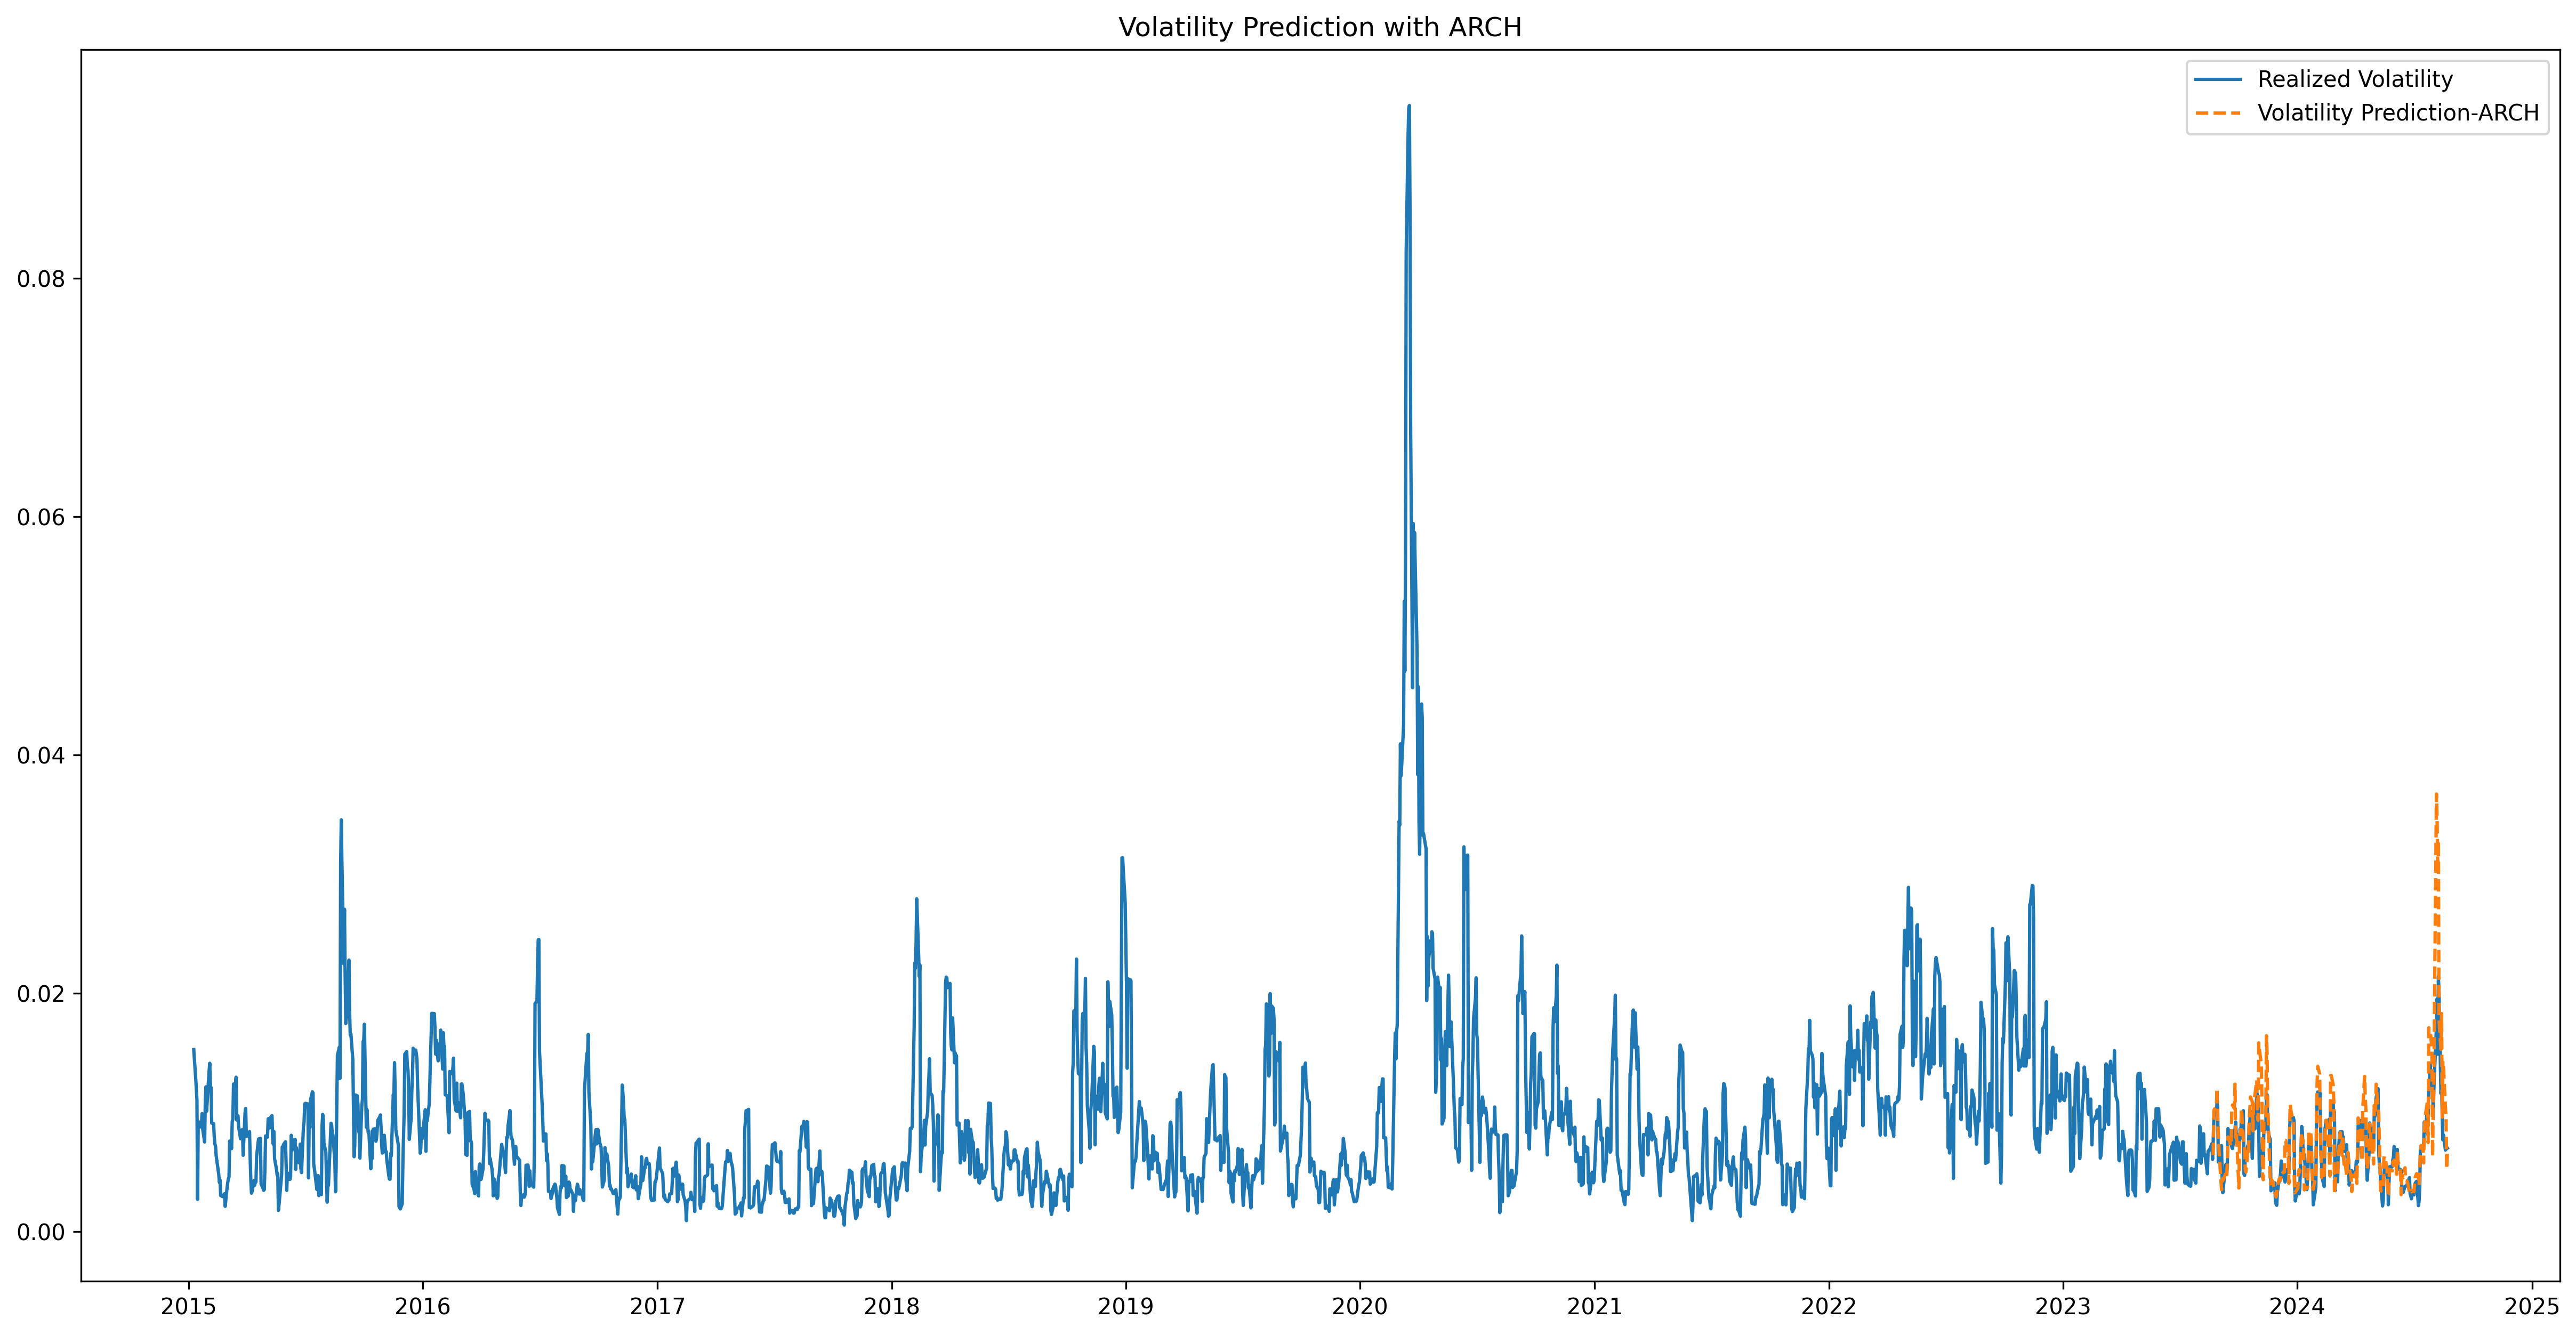

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-ARCH', linestyle='--')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()

### GARCH

In [11]:
# Define the ticker symbol for the stock
ticker_symbol = "AAPL"
# Retrieve historical data using yfinance
stock_data = yf.download(ticker_symbol, start="2010-01-01", end="2024-07-30")
# Calculate daily returns
stock_data["Returns"] = np.log(
    stock_data["Close"] / stock_data["Close"].shift(1))
# Calculate daily volatility
stock_data["Volatility"] = stock_data["Returns"].rolling(
    window=252).std() * np.sqrt(252)
# Remove missing values
stock_data = stock_data.dropna()
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2011-01-03  11.630000  11.795000  11.601429  11.770357   9.939776  445138400   
2011-01-04  11.872857  11.875000  11.719643  11.831786   9.991649  309080800   
2011-01-05  11.769643  11.940714  11.767857  11.928571  10.073381  255519600   
2011-01-06  11.954286  11.973214  11.889286  11.918929  10.065239  300428800   
2011-01-07  11.928214  12.012500  11.853571  12.004286  10.137324  311931200   

             Returns  Volatility  
Date                              
2011-01-03  0.021500    0.267238  
2011-01-04  0.005205    0.267260  
2011-01-05  0.008147    0.266740  
2011-01-06 -0.000809    0.266728  
2011-01-07  0.007136    0.266738  


In [12]:
# Calculate basic statistics
mean_volatility = stock_data["Volatility"].mean()
median_volatility = stock_data["Volatility"].median()
min_volatility = stock_data["Volatility"].min()
max_volatility = stock_data["Volatility"].max()
# Display the statistics
print("Mean Volatility:", mean_volatility)
print("Median Volatility:", median_volatility)
print("Minimum Volatility:", min_volatility)
print("Maximum Volatility:", max_volatility)

Mean Volatility: 0.2744726895249122
Median Volatility: 0.2657534761490383
Minimum Volatility: 0.16879256252237965
Maximum Volatility: 0.4746781009399715


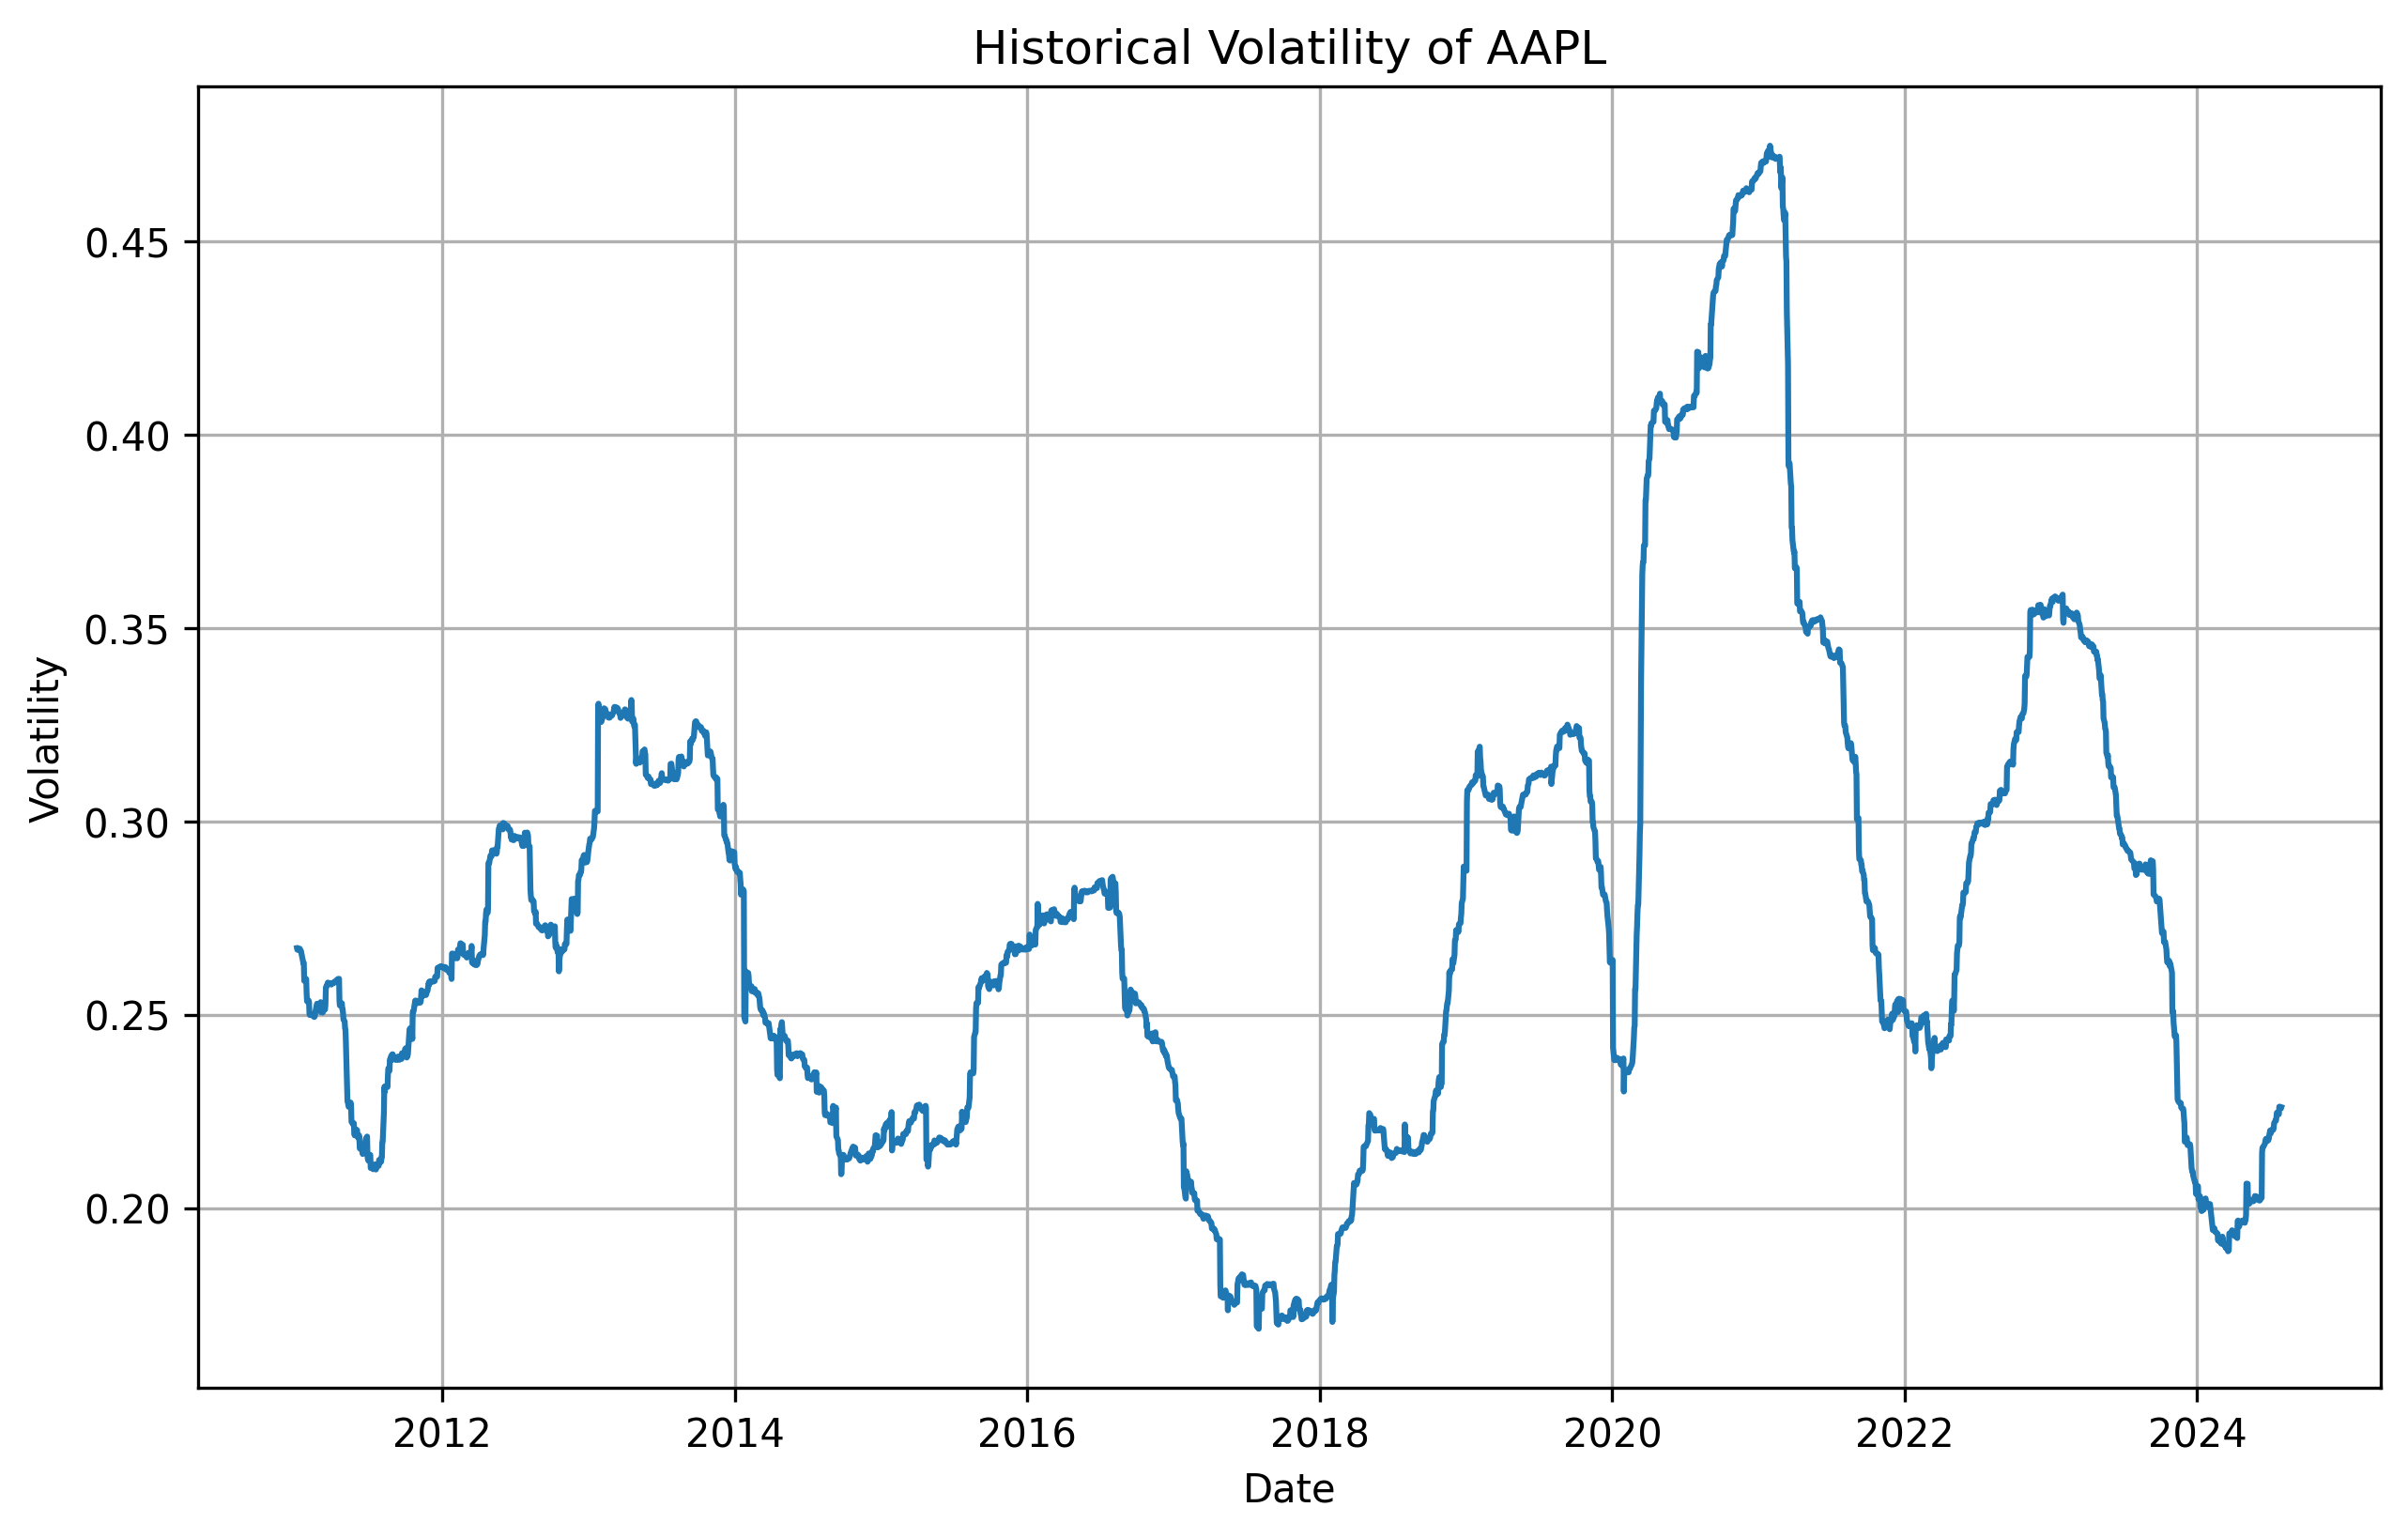

In [13]:
import matplotlib.pyplot as plt
# Plot the historical volatility
plt.figure(figsize=(10, 6))
plt.plot(stock_data["Volatility"])
plt.title("Historical Volatility of AAPL")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

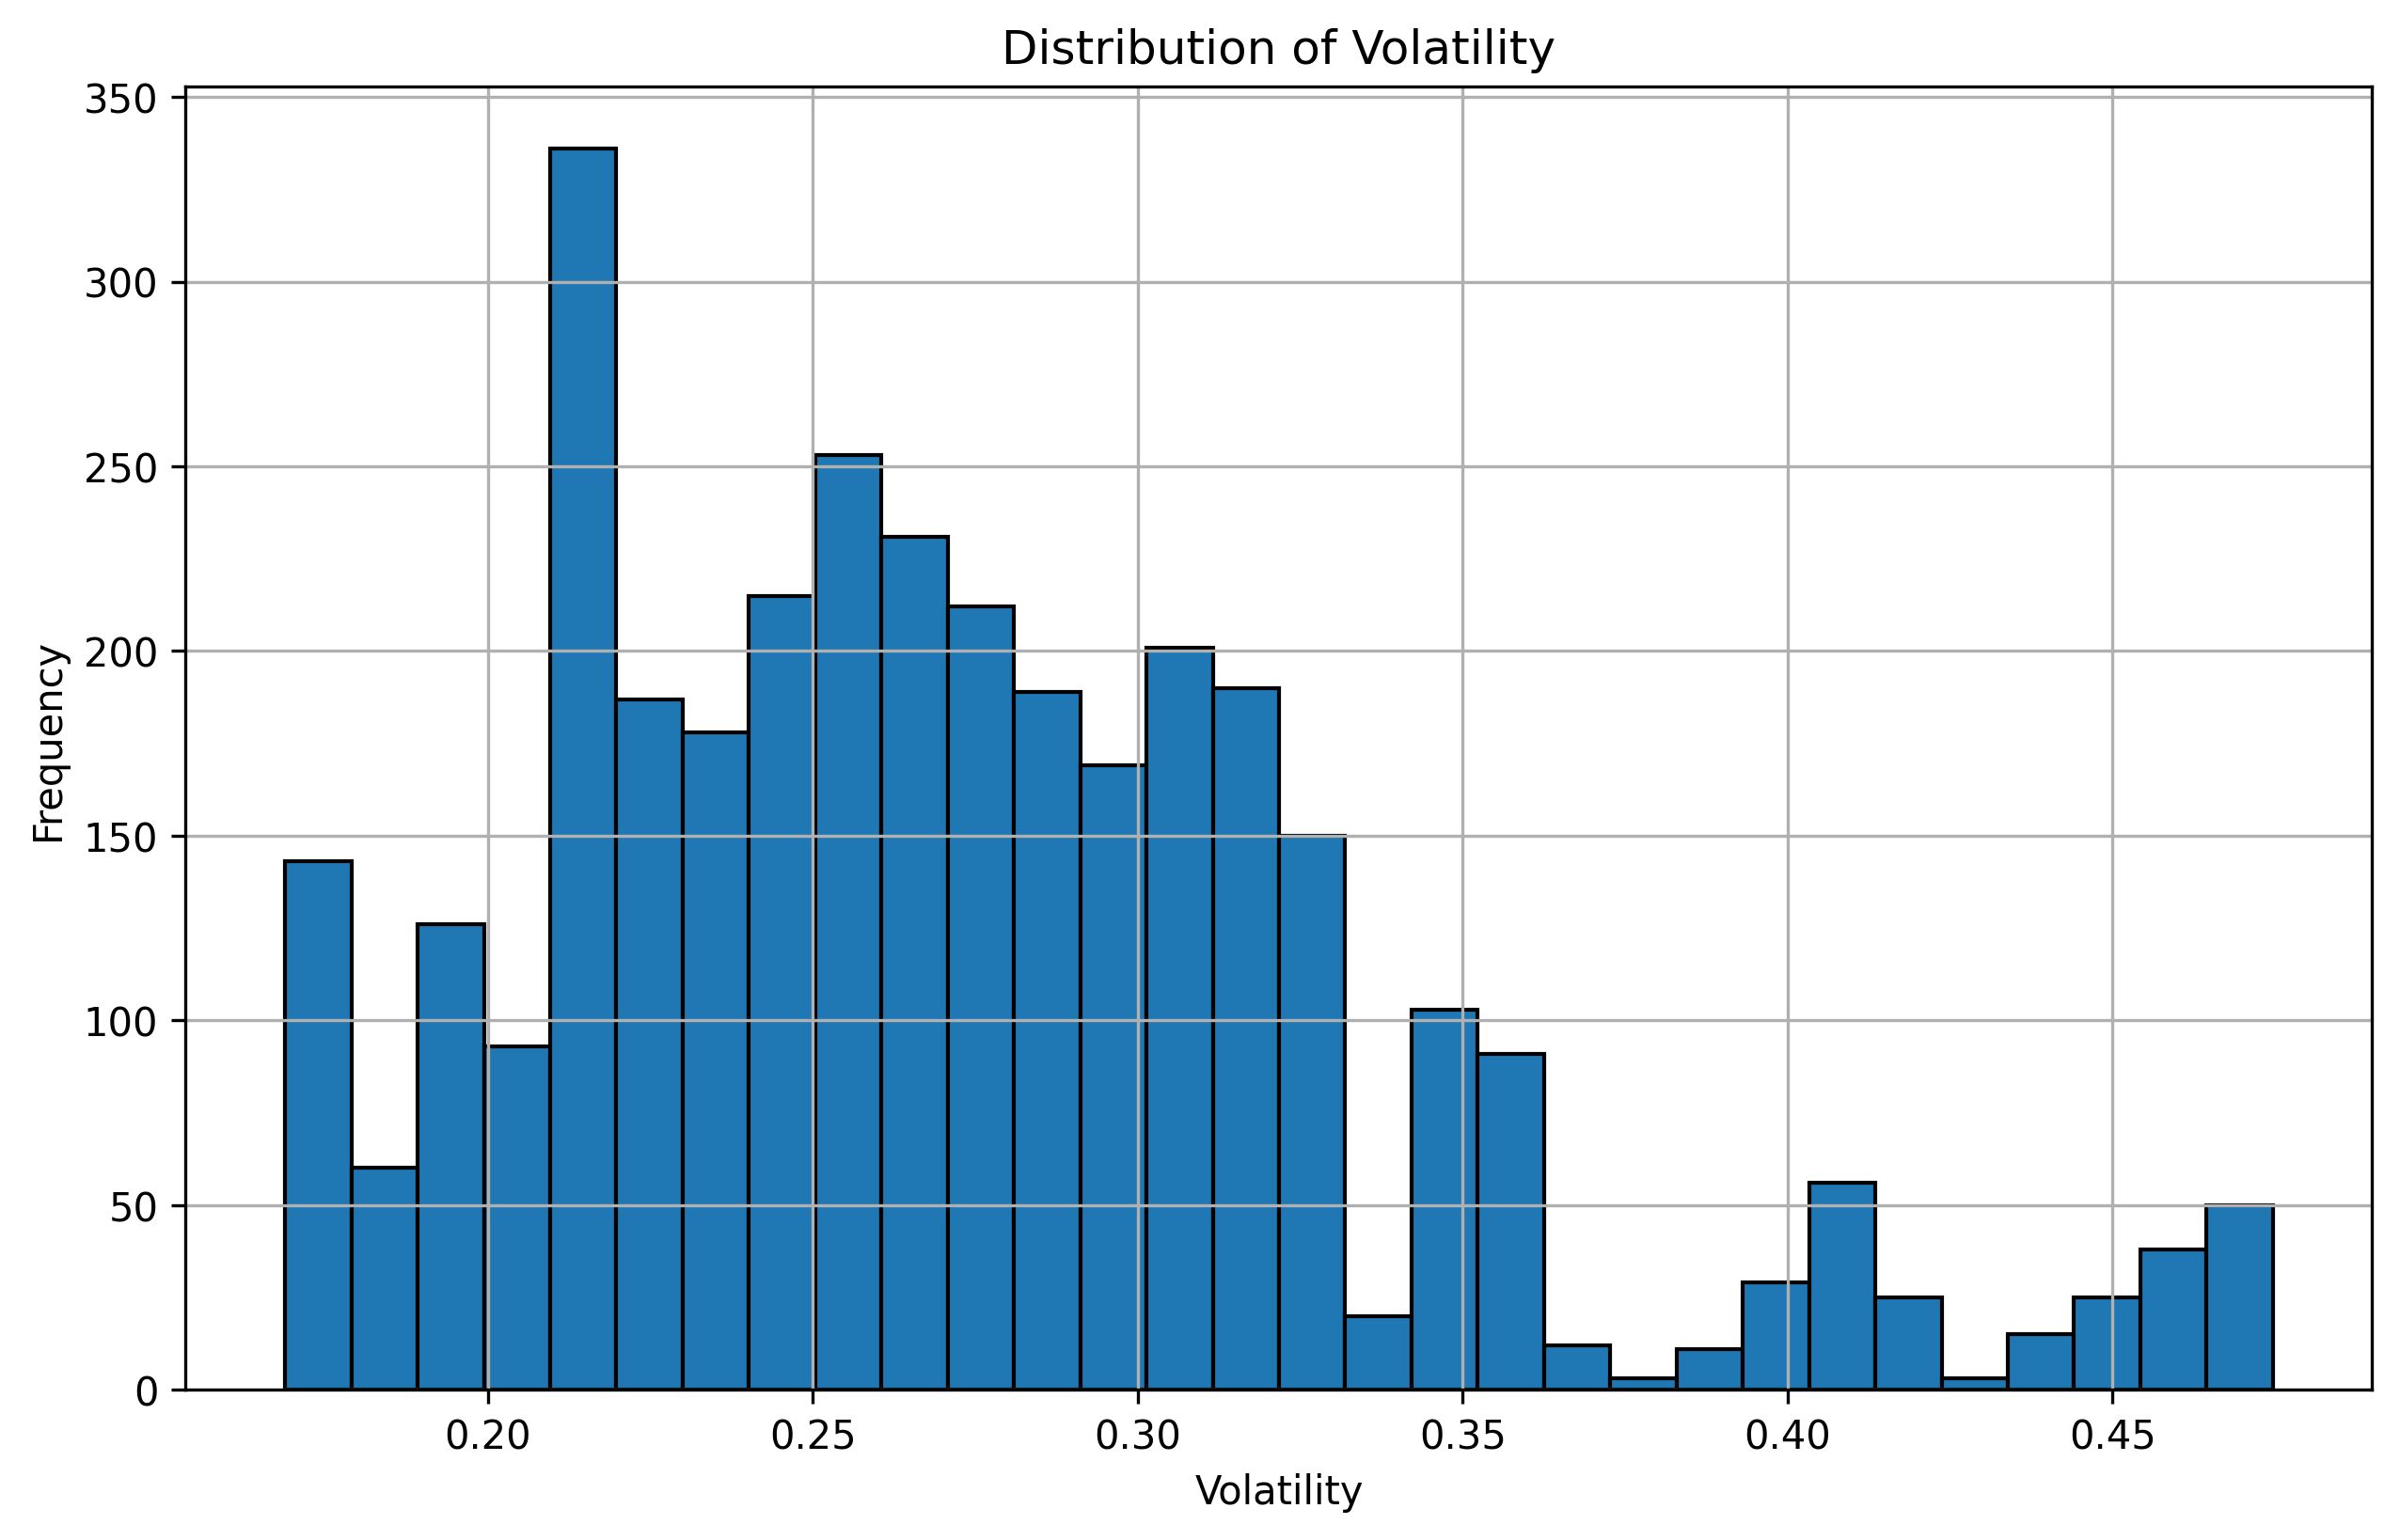

In [14]:
# Plot the distribution of volatility
plt.figure(figsize=(10, 6))
plt.hist(stock_data["Volatility"], bins=30, edgecolor="black")
plt.title("Distribution of Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [15]:
import arch
# Create a GARCH model
garch_model = arch.arch_model(stock_data["Returns"], vol="Garch", p=1, q=1)
# Fit the model
garch_model_fit = garch_model.fit()
# Display the model summary
print(garch_model_fit.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7494528922.195189
Iteration:      2,   Func. Count:     19,   Neg. LLF: 153541083142823.7
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1.639508395515625e+17
Iteration:      4,   Func. Count:     42,   Neg. LLF: 391216607.6627006
Iteration:      5,   Func. Count:     54,   Neg. LLF: -9163.492526439091
Optimization terminated successfully    (Exit mode 0)
            Current function value: -9163.492535681851
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                9163.49
Distribution:                  Normal   AIC:                          -18319.0
Method:            Maximum Likel

In [16]:
# Generate volatility forecasts
forecast_volatility = garch_model_fit.forecast(horizon=1)
# Extract the forecasted volatility
forecasted_volatility = np.sqrt(forecast_volatility.variance.values[-1, :])
# Display the forecasted volatility
print("Forecasted Volatility:", forecasted_volatility)

Forecasted Volatility: [0.01629718]


In [17]:
# Extract the actual volatility
actual_volatility = stock_data["Volatility"].values[-1]
# Calculate the root mean squared error
rmse = np.sqrt(np.mean((forecasted_volatility - actual_volatility) ** 2))
# Display the RMSE
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.20978571406578111


In [18]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(ret, mean='zero', vol='GARCH', p=p, o=0, q=q)\
            .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
garch = arch_model(ret, mean='zero', vol='GARCH',
                   p=best_param[0], o=0, q=best_param[1])\
    .fit(disp='off')
print(garch.summary())
forecast = garch.forecast(start=split_date[0])
forecast_garch = forecast

                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3128.74
Distribution:                  Normal   AIC:                           6263.49
Method:            Maximum Likelihood   BIC:                           6280.87
                                        No. Observations:                 2425
Date:                Wed, Sep 25 2024   Df Residuals:                     2425
Time:                        13:32:31   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0357  9.864e-03      3.624  2.899e-04 [1.

In [19]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] / 100,
                         np.sqrt(forecast_garch
                         .variance.iloc[-len(split_date):]
                         / 100)))
print('The RMSE value of GARCH model is {:.4f}'.format(rmse_garch))

The RMSE value of GARCH model is 0.0766


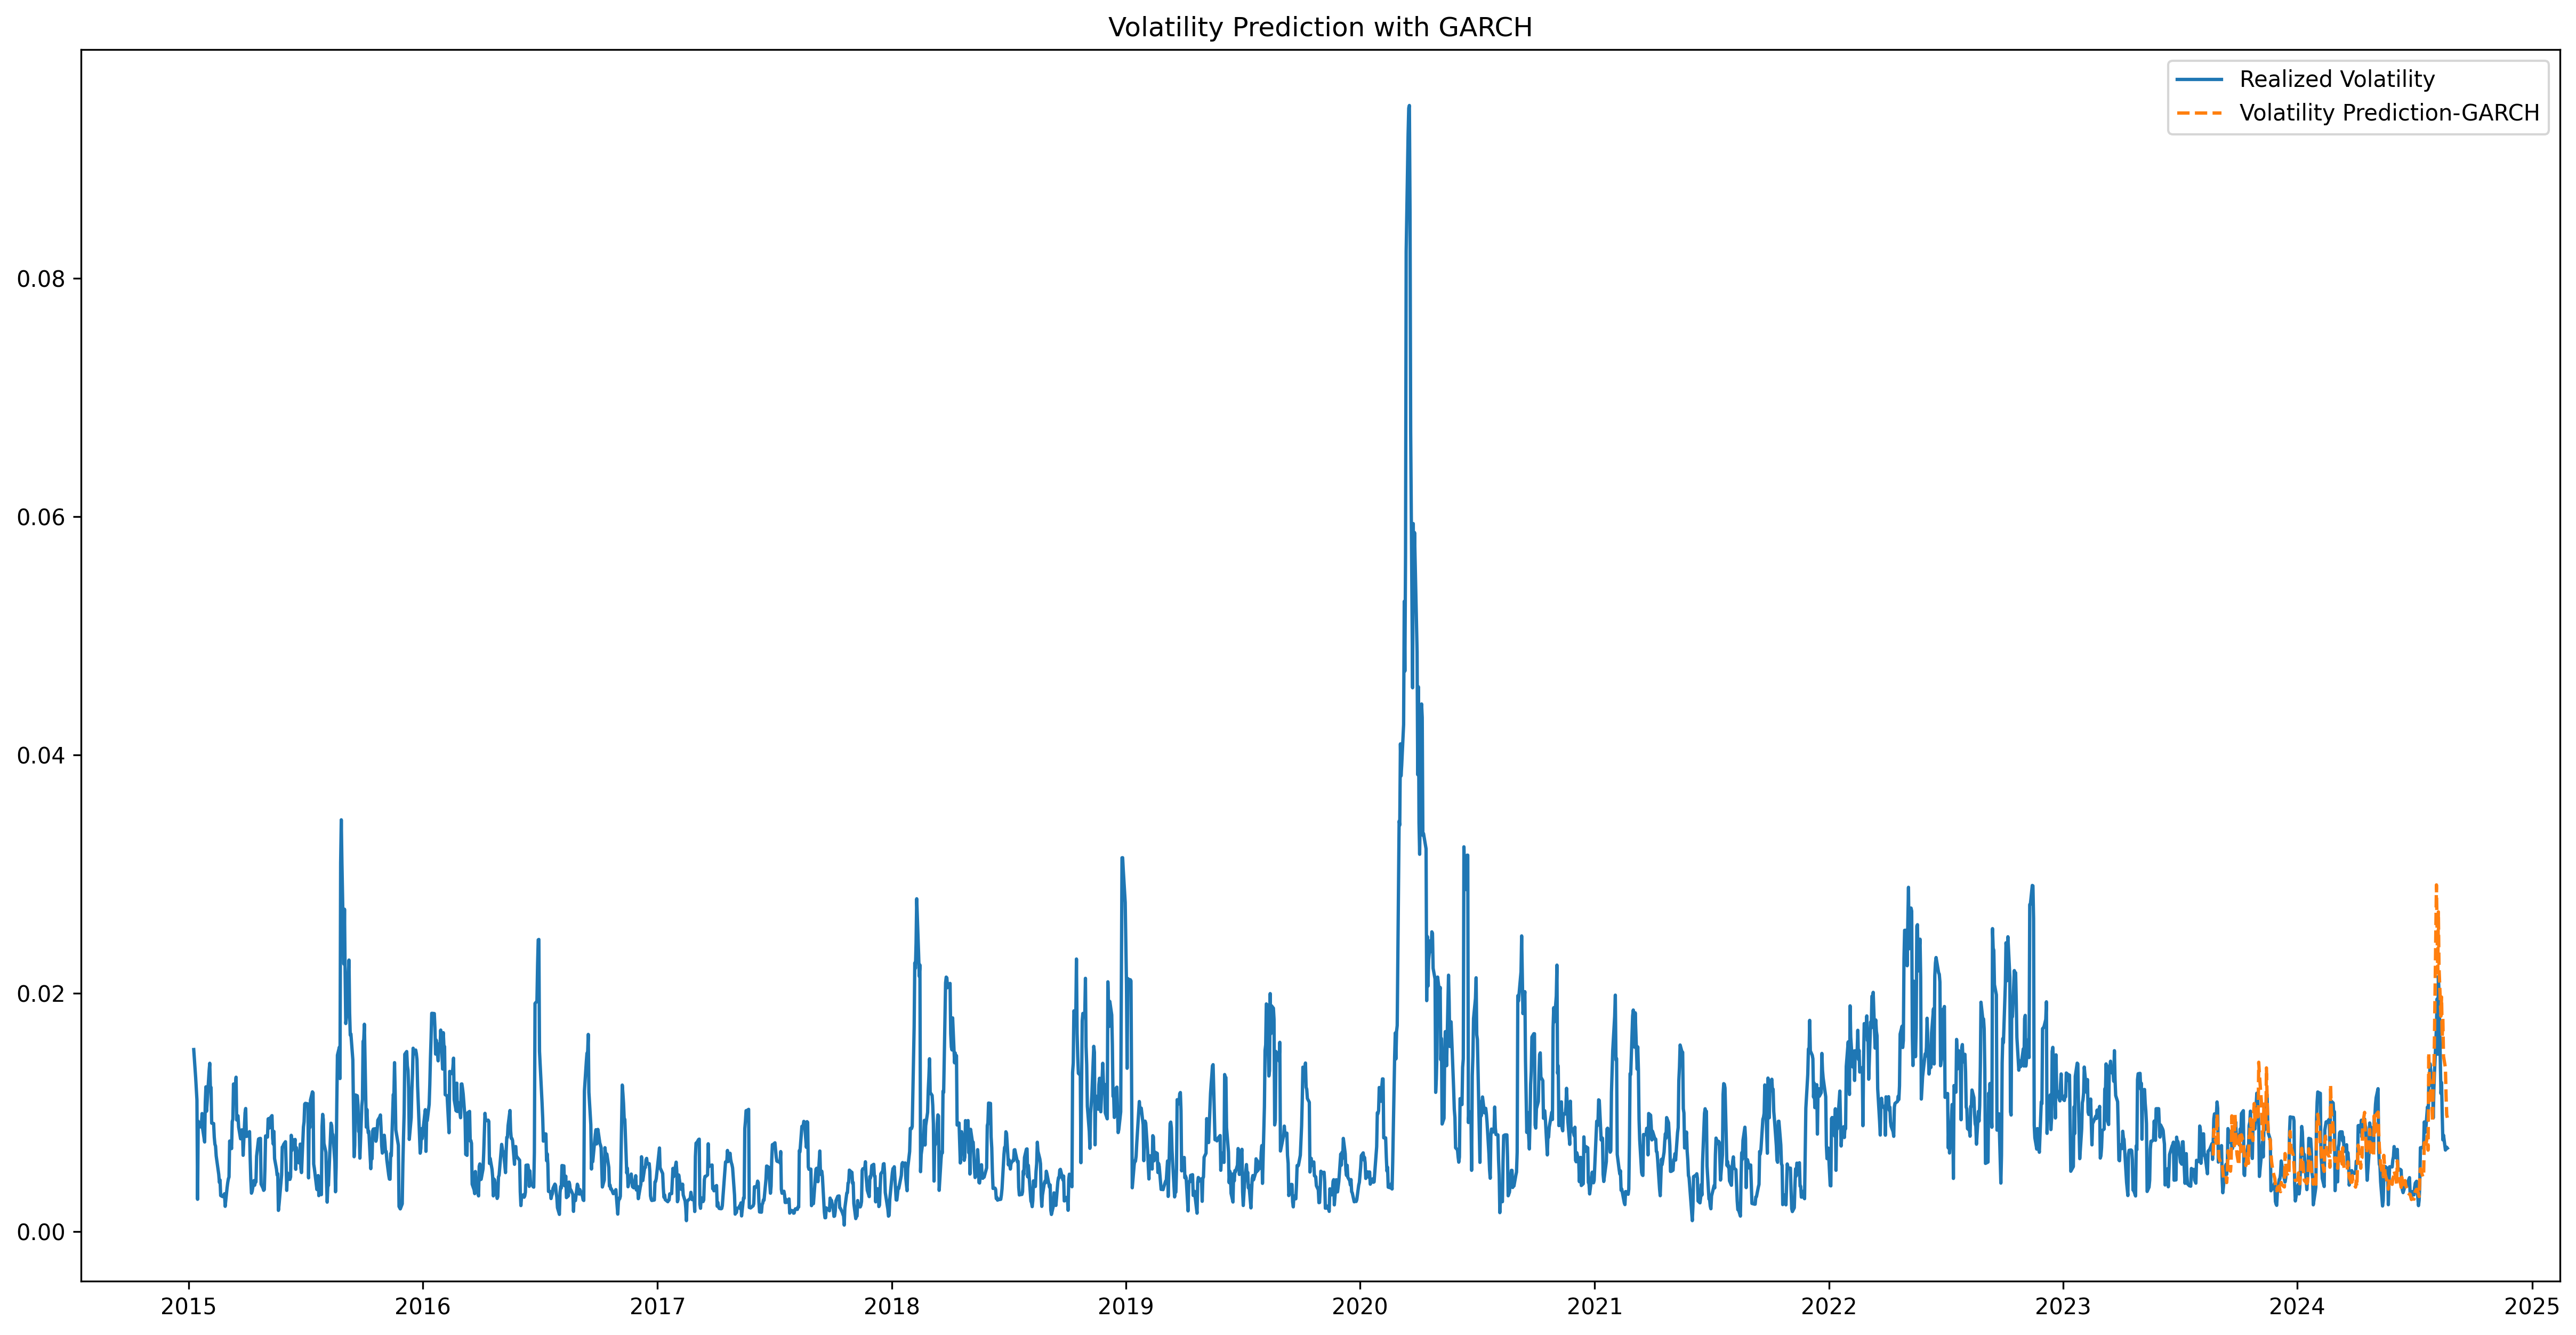

In [20]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_garch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-GARCH', linestyle='--')
plt.title('Volatility Prediction with GARCH', fontsize=12)
plt.legend()
plt.show()

### EGARCH

In [21]:
bic_egarch = []

for p in range(1, 5):
    for q in range(1, 5):
        egarch = arch_model(ret, mean='zero', vol='EGARCH', p=p, q=q)\
            .fit(disp='off')
        bic_egarch.append(egarch.bic)
        if egarch.bic == np.min(bic_egarch):
            best_param = p, q
egarch = arch_model(ret, mean='zero', vol='EGARCH',
                    p=best_param[0], q=best_param[1])\
    .fit(disp='off')
print(egarch.summary())
forecast = egarch.forecast(start=split_date[0])
forecast_egarch = forecast

                       Zero Mean - EGARCH Model Results                       
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -3143.85
Distribution:                  Normal   AIC:                           6293.69
Method:            Maximum Likelihood   BIC:                           6311.07
                                        No. Observations:                 2425
Date:                Wed, Sep 25 2024   Df Residuals:                     2425
Time:                        13:32:36   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      3.9618e-03  7.007e-03      0.565      0.572 

In [22]:
rmse_egarch = np.sqrt(mse(realized_vol[-n:] / 100,
                          np.sqrt(forecast_egarch.variance
                          .iloc[-len(split_date):] / 100)))
print('The RMSE value of EGARCH models is {:.4f}'.format(rmse_egarch))

The RMSE value of EGARCH models is 0.0794


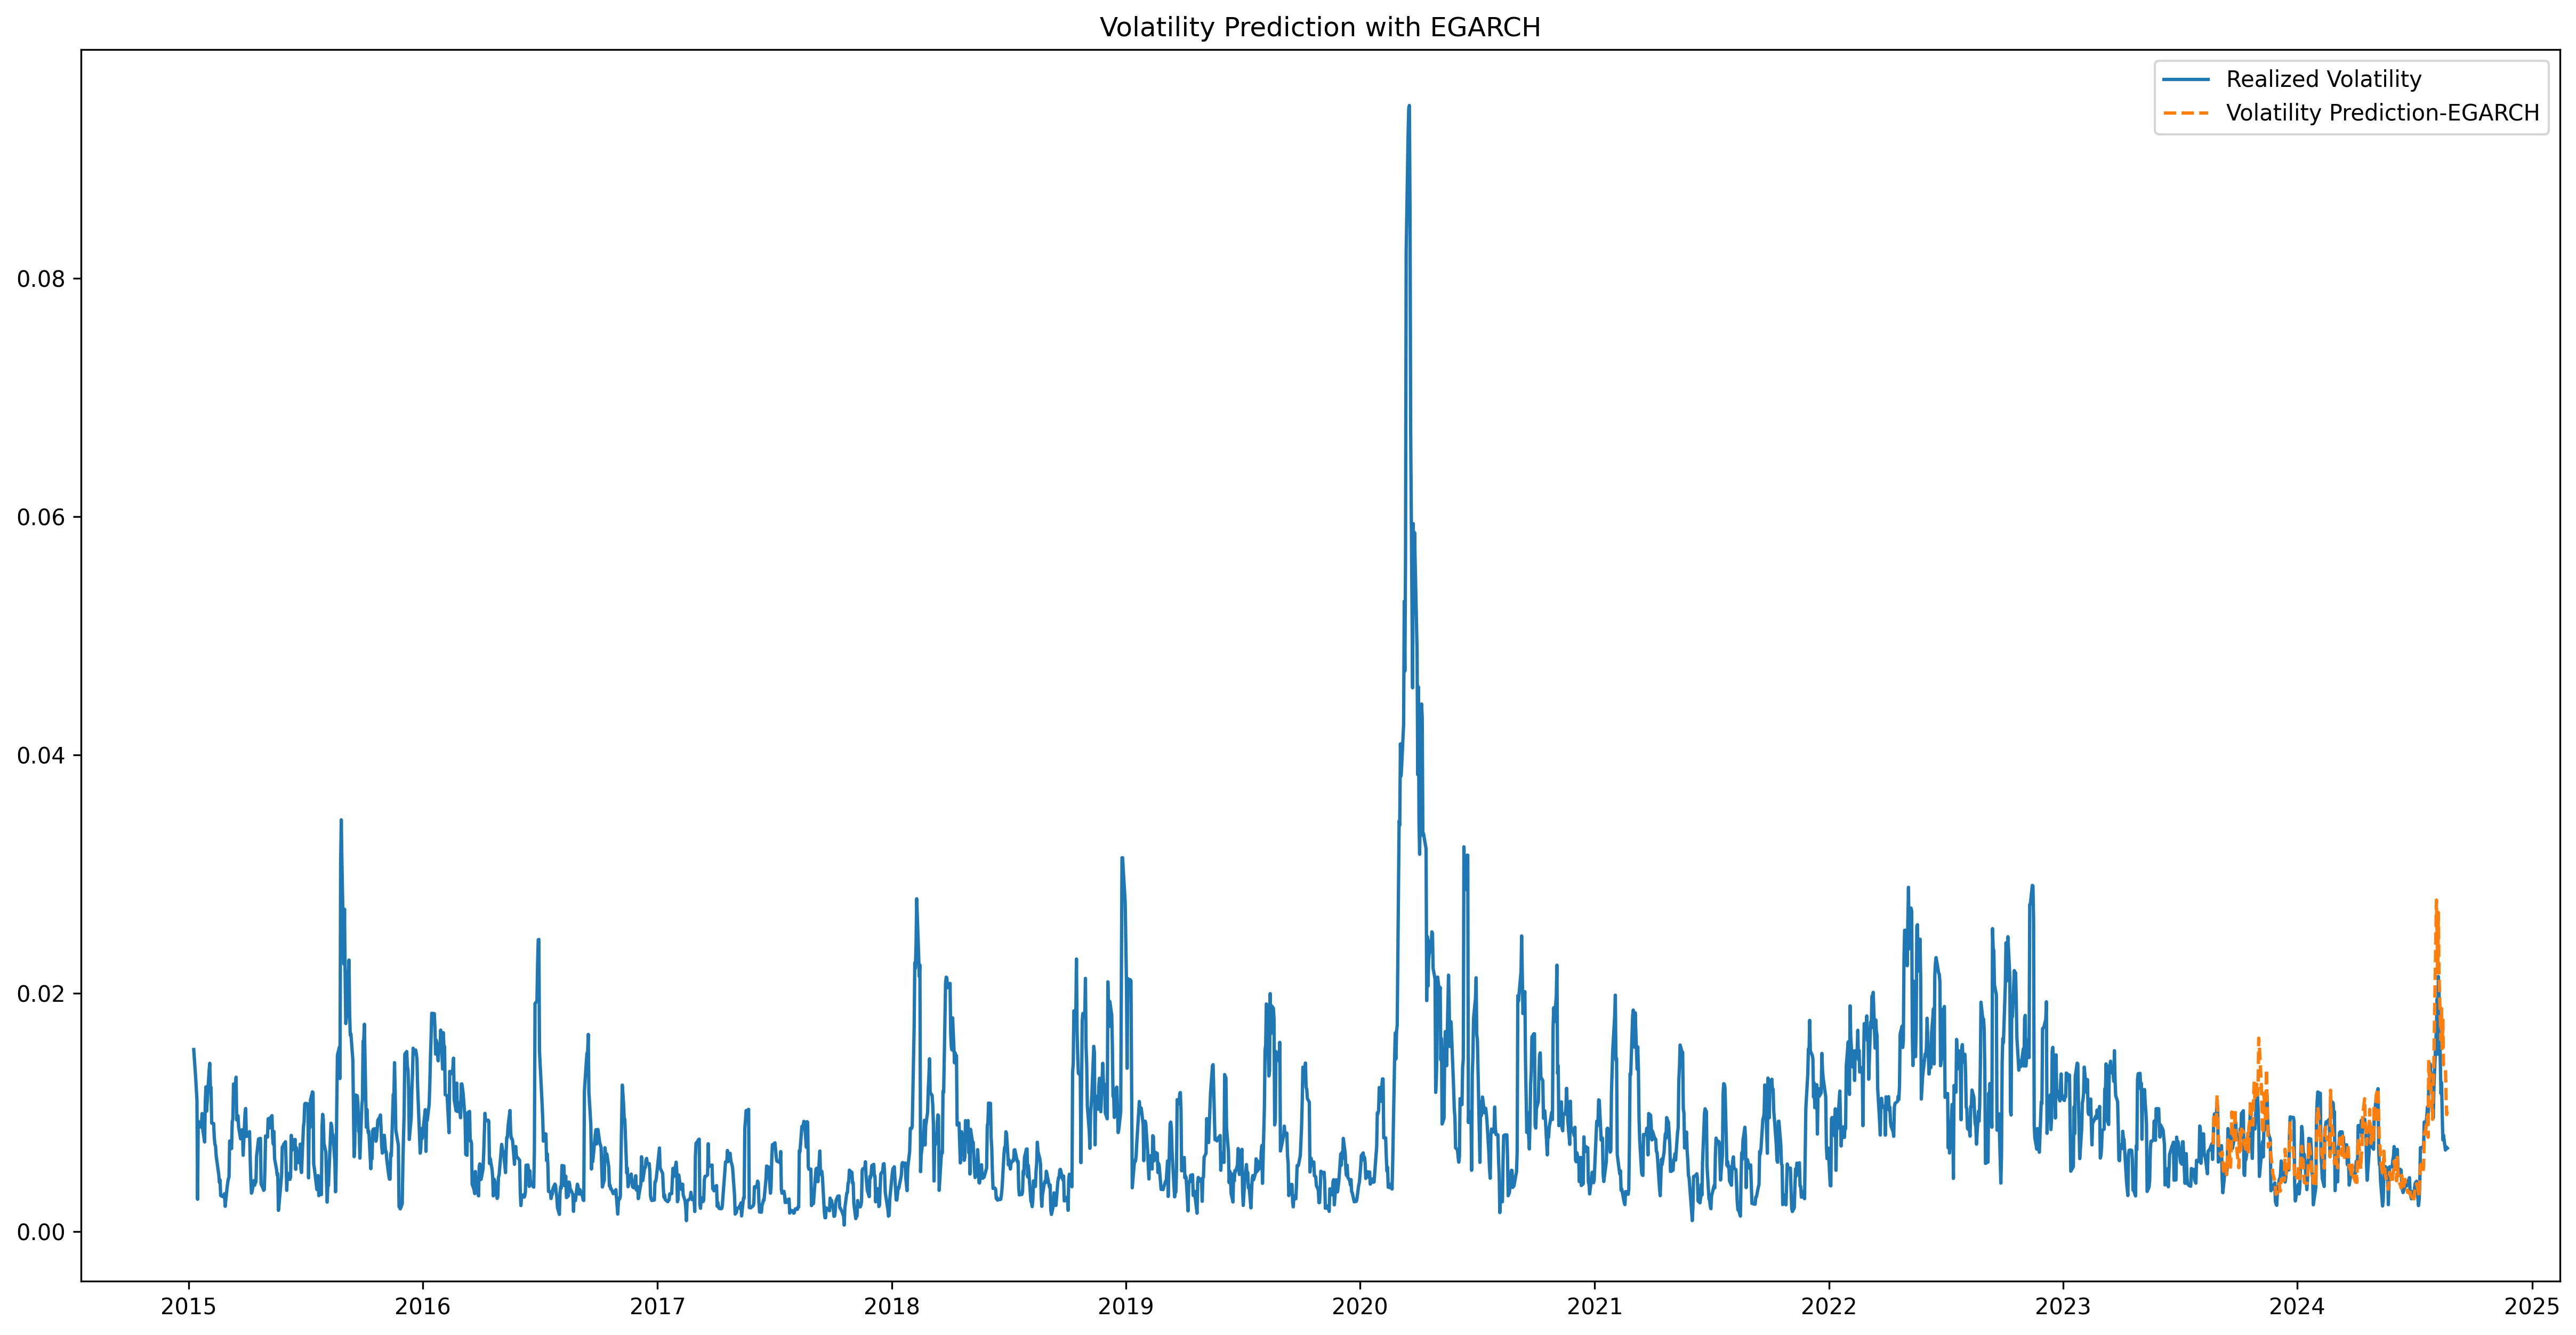

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_egarch.variance.iloc[-len(split_date):] / 100,
         label='Volatility Prediction-EGARCH', linestyle='--')
plt.title('Volatility Prediction with EGARCH', fontsize=12)
plt.legend()
plt.show()

## Machine Learning Models

In [24]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.rename(columns={'Adj Close': 'realized_vol'}, inplace=True)

In [25]:
realized_vol.reset_index(drop=True, inplace=True)

In [26]:
returns_power = ret ** 2
returns_power = pd.DataFrame(returns_power)
returns_power.rename(columns={'Adj Close': 'returns_svm'}, inplace=True)
returns_power = returns_power.reset_index(drop=True)

In [27]:
for lag in range(1, 6):
    realized_vol[f'realized_vol_lag{lag}'] = realized_vol['realized_vol'].shift(
        lag)
    returns_power[f'returns_svm_lag{lag}'] = returns_power['returns_svm'].shift(
        lag)

In [28]:
X = pd.concat([realized_vol.iloc[9:], returns_power.iloc[9:]],
              axis=1, ignore_index=False)

In [29]:
returns_power

returns_svm  returns_svm_lag1  returns_svm_lag2  returns_svm_lag3  \
0        3.340891               NaN               NaN               NaN   
1        0.790938          3.340891               NaN               NaN   
2        1.352532          0.790938          3.340891               NaN   
3        3.199906          1.352532          0.790938          3.340891   
4        0.706240          3.199906          1.352532          0.790938   
...           ...               ...               ...               ...   
2420     0.039592          2.602817          0.146209          2.838409   
2421     0.945228          0.039592          2.602817          0.146209   
2422     0.039385          0.945228          0.039592          2.602817   
2423     0.179749          0.039385          0.945228          0.039592   
2424     0.797950          0.179749          0.039385          0.945228   

      returns_svm_lag4  returns_svm_lag5  
0                  NaN               NaN  
1                  NaN               NaN  
2                  NaN               NaN  
3                  NaN               NaN  
4             3.340891               NaN  
...                ...               ...  
2420          0.000019          0.218246  
2421          2.838409          0.000019  
2422          0.146209          2.838409  
2423          2.602817          0.146209  
2424          0.039592          2.602817  

[2425 rows x 6 columns]

#### SVR-Linear¶

In [30]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
svr_lin = SVR(kernel='linear')
clf = RandomizedSearchCV(svr_lin, para_grid, random_state=42)

In [31]:
clf.fit(X.iloc[:-n].values,
        realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,))

RandomizedSearchCV(estimator=SVR(kernel='linear'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000209DFCC5060>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000209DFCC6620>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000209DCBFB460>},
                   random_state=42)

In [32]:
predict_svr_lin = clf.predict(X.iloc[-n:])
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [33]:
rmse_svr = np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100,
                       predict_svr_lin / 100))
print('The RMSE value of SVR with Linear Kernel is {:.6f}'
      .format(rmse_svr))

The RMSE value of SVR with Linear Kernel is 0.000623


In [34]:
realized_vol.index = ret.index

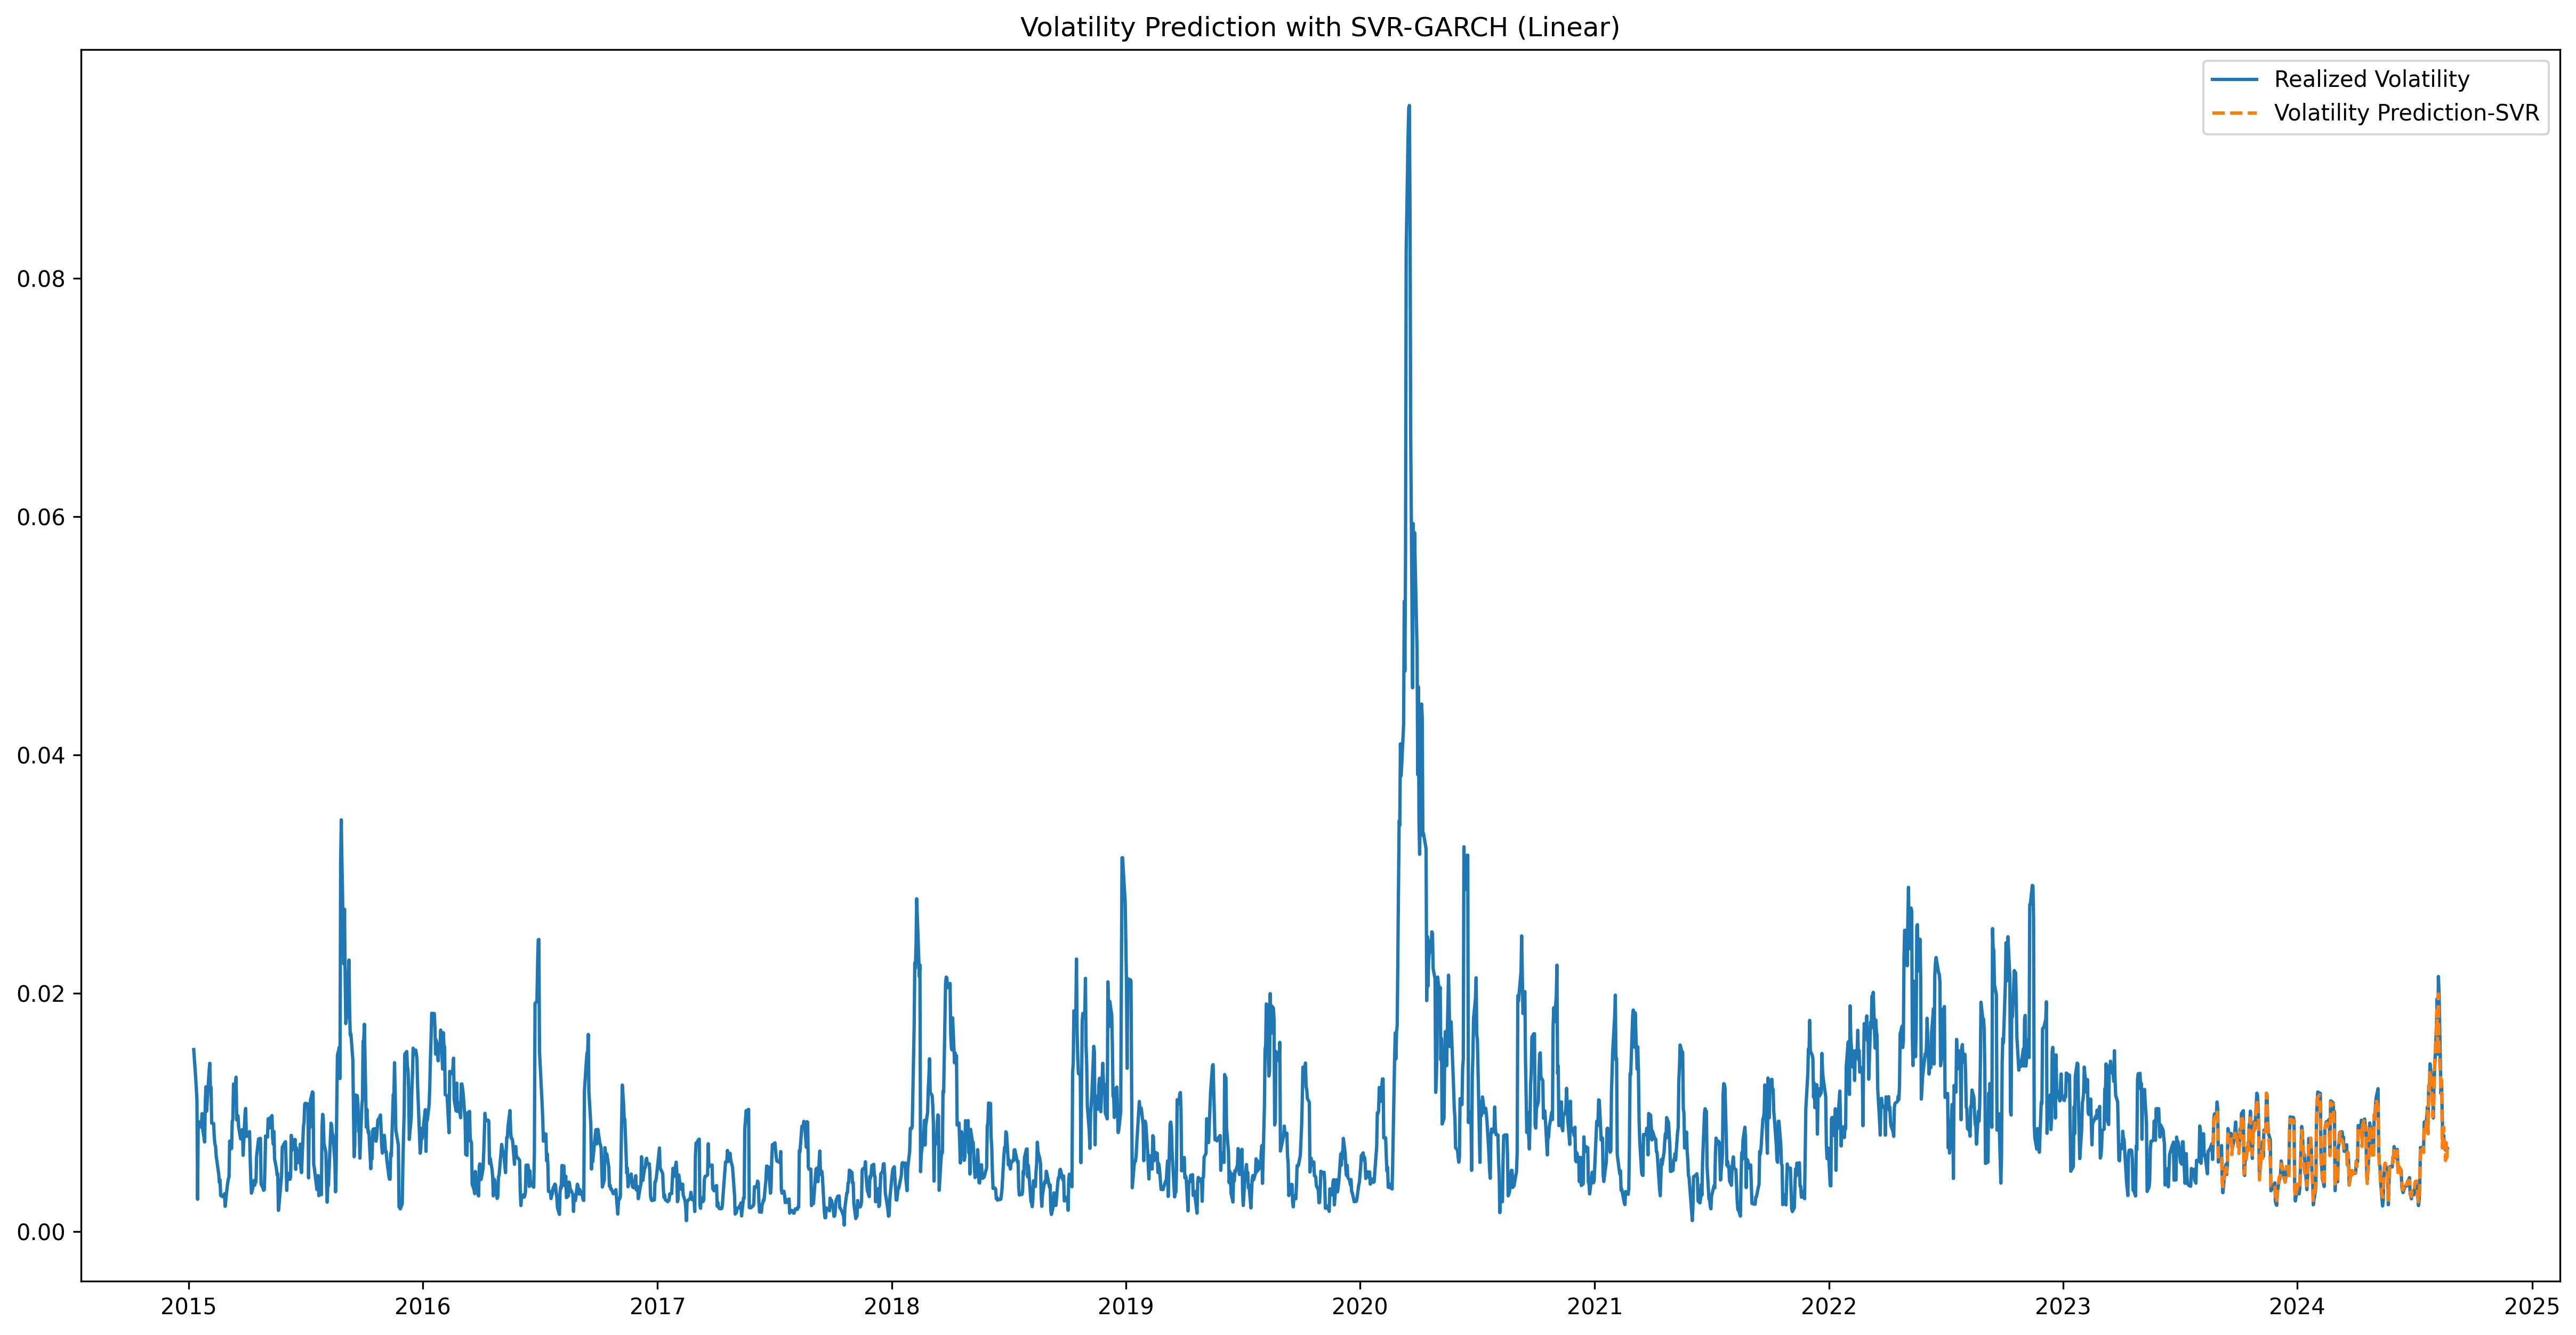

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(predict_svr_lin / 100, label='Volatility Prediction-SVR', linestyle='--')
plt.title('Volatility Prediction with SVR-GARCH (Linear)', fontsize=12)
plt.legend()
plt.show()

#### SVR-RBF

In [36]:
para_grid = {'gamma': sp_rand(),
             'C': sp_rand(),
             'epsilon': sp_rand()}
clf = RandomizedSearchCV(svr_rbf, para_grid, random_state=42)
clf.fit(X.iloc[:-n].values,
        realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,))

RandomizedSearchCV(estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000209DCBFAB30>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000209E51A00A0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000209E51A15D0>},
                   random_state=42)

In [37]:
predict_svr_rbf = clf.predict(X.iloc[-n:])
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [38]:
rmse_svr_rbf = np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100,
                           predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is  {:.6f}'
      .format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is  0.001522


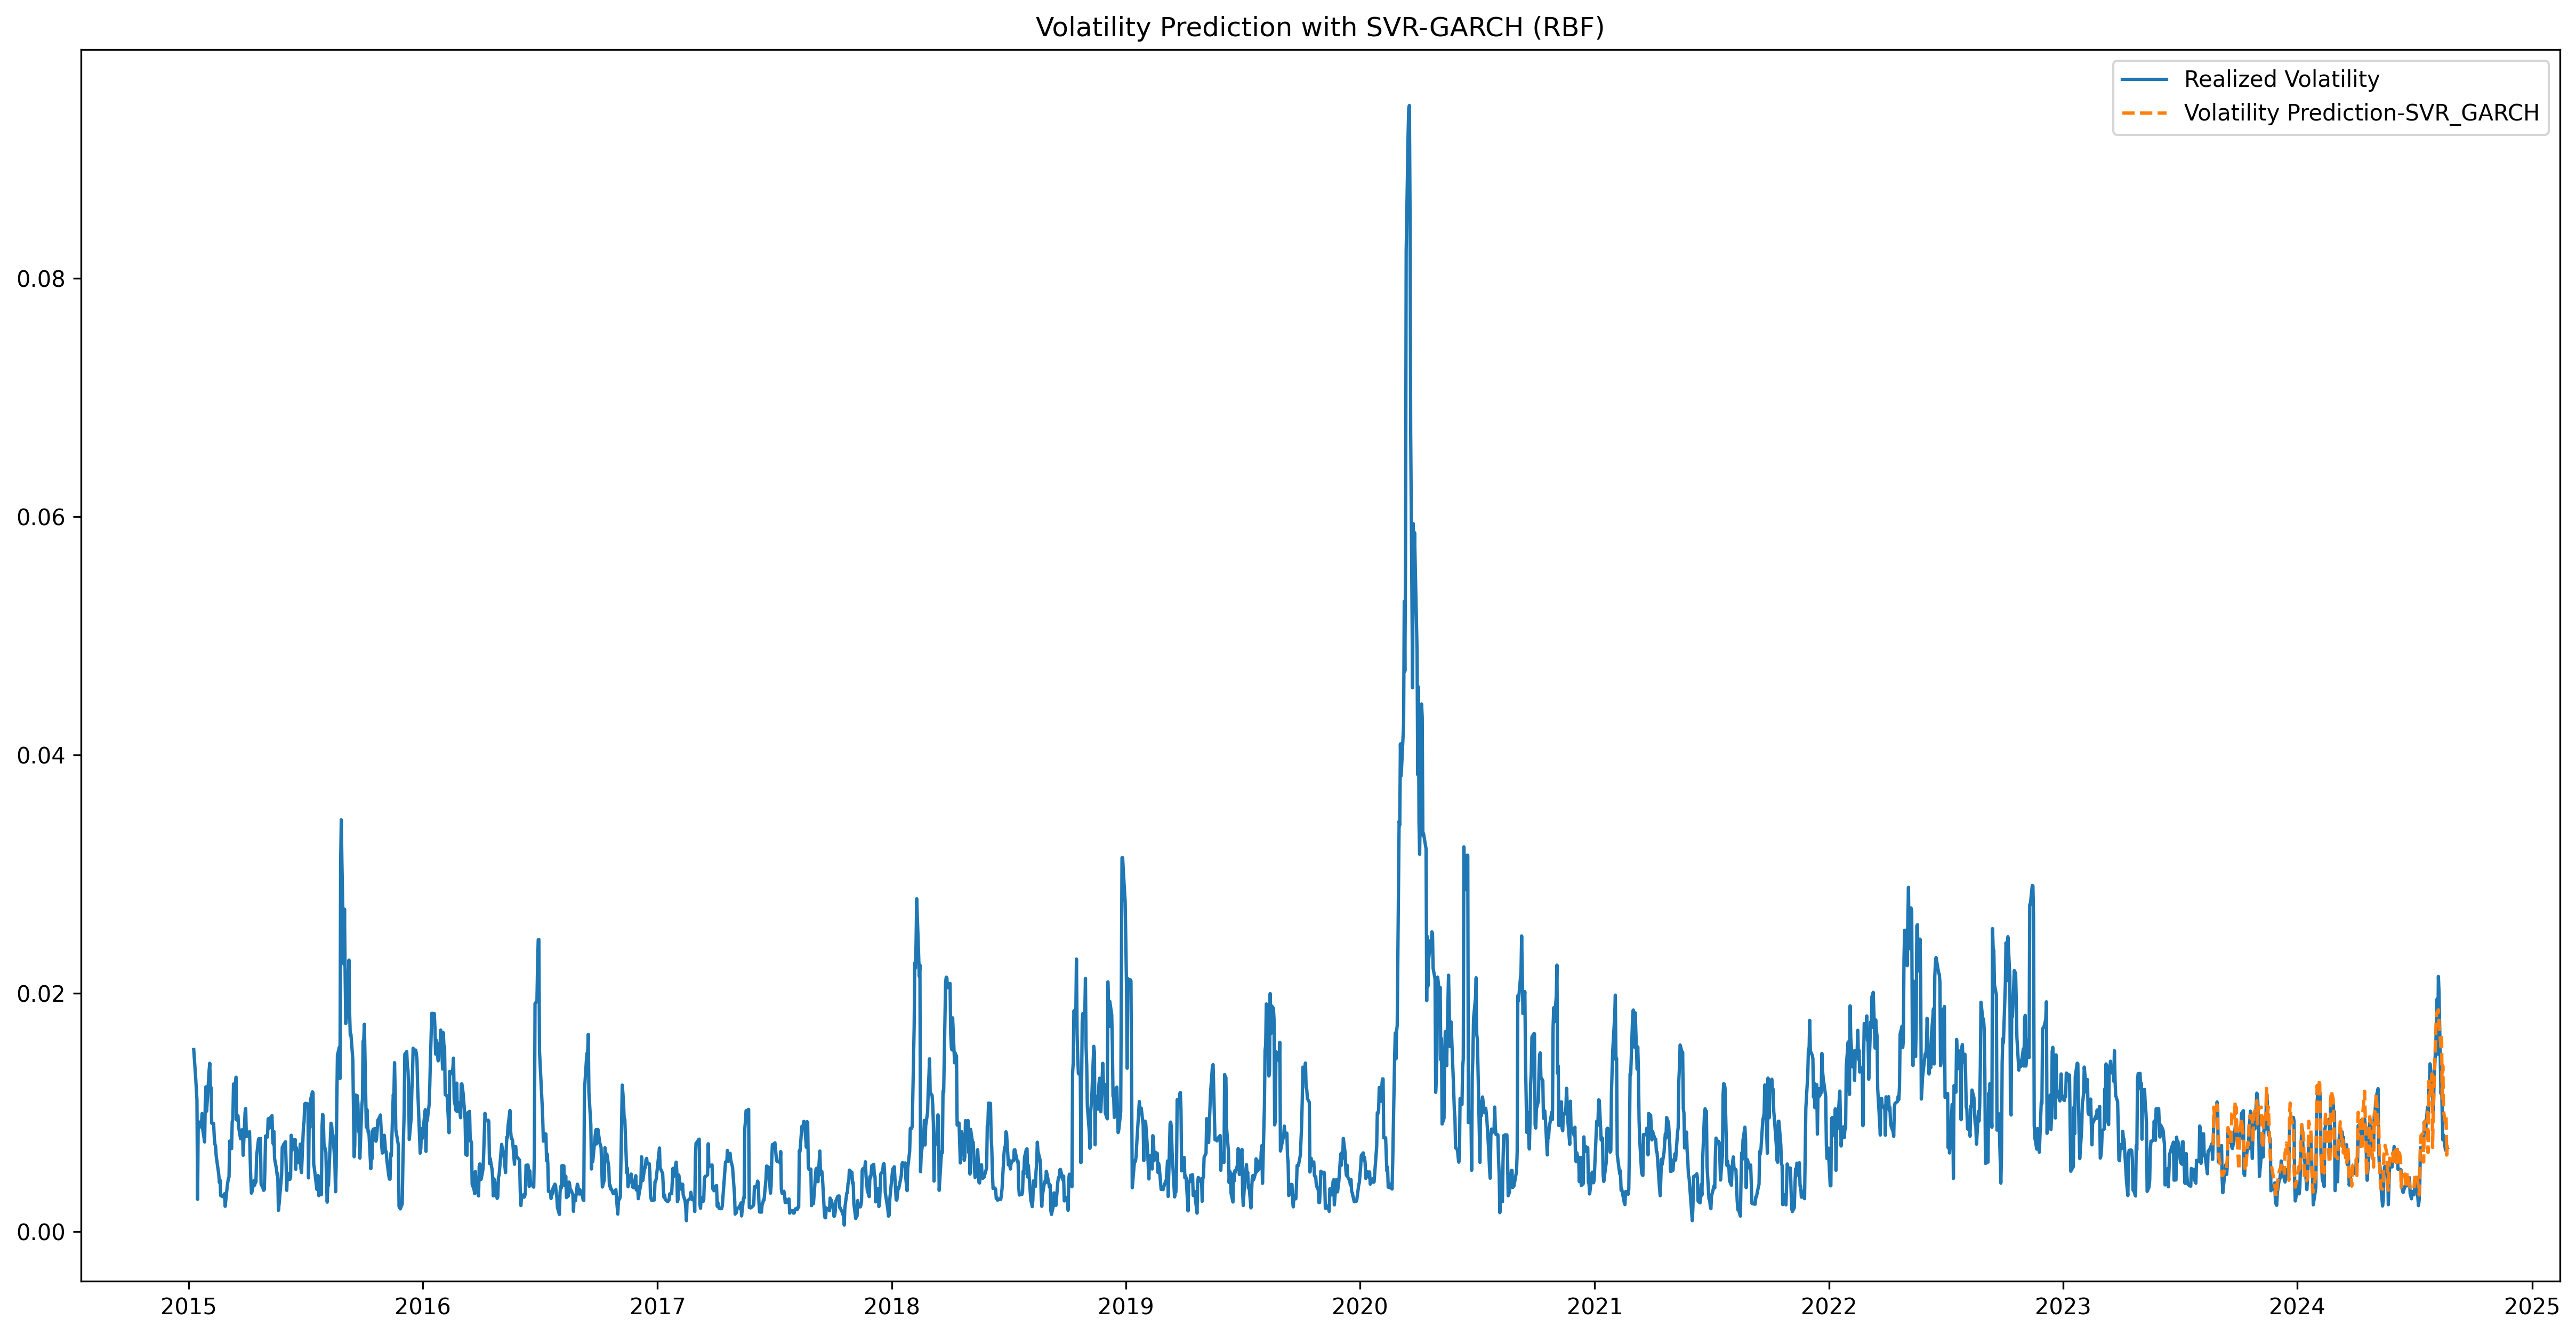

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(predict_svr_rbf / 100,
         label='Volatility Prediction-SVR_GARCH', linestyle='--')
plt.title('Volatility Prediction with SVR-GARCH (RBF)', fontsize=12)
plt.legend()
plt.show()

 #### Linear Regression

In [40]:
lin_reg = LinearRegression()

In [41]:
lin_reg.fit(X.iloc[:-n].values,
            realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,))

LinearRegression()

In [42]:
predict_lin_reg = lin_reg.predict(X.iloc[-n:])
predict_lin_reg = pd.DataFrame(predict_lin_reg, index=ret.iloc[-n:].index)

In [43]:
rmse_lin_reg = np.sqrt(
    mse(realized_vol['realized_vol'].iloc[-n:] / 100, predict_lin_reg.values / 100))
print('The RMSE value of Linear Regression is {:.6f}'.format(rmse_lin_reg))

The RMSE value of Linear Regression is 0.000596


In [44]:
realized_vol.index = ret.index

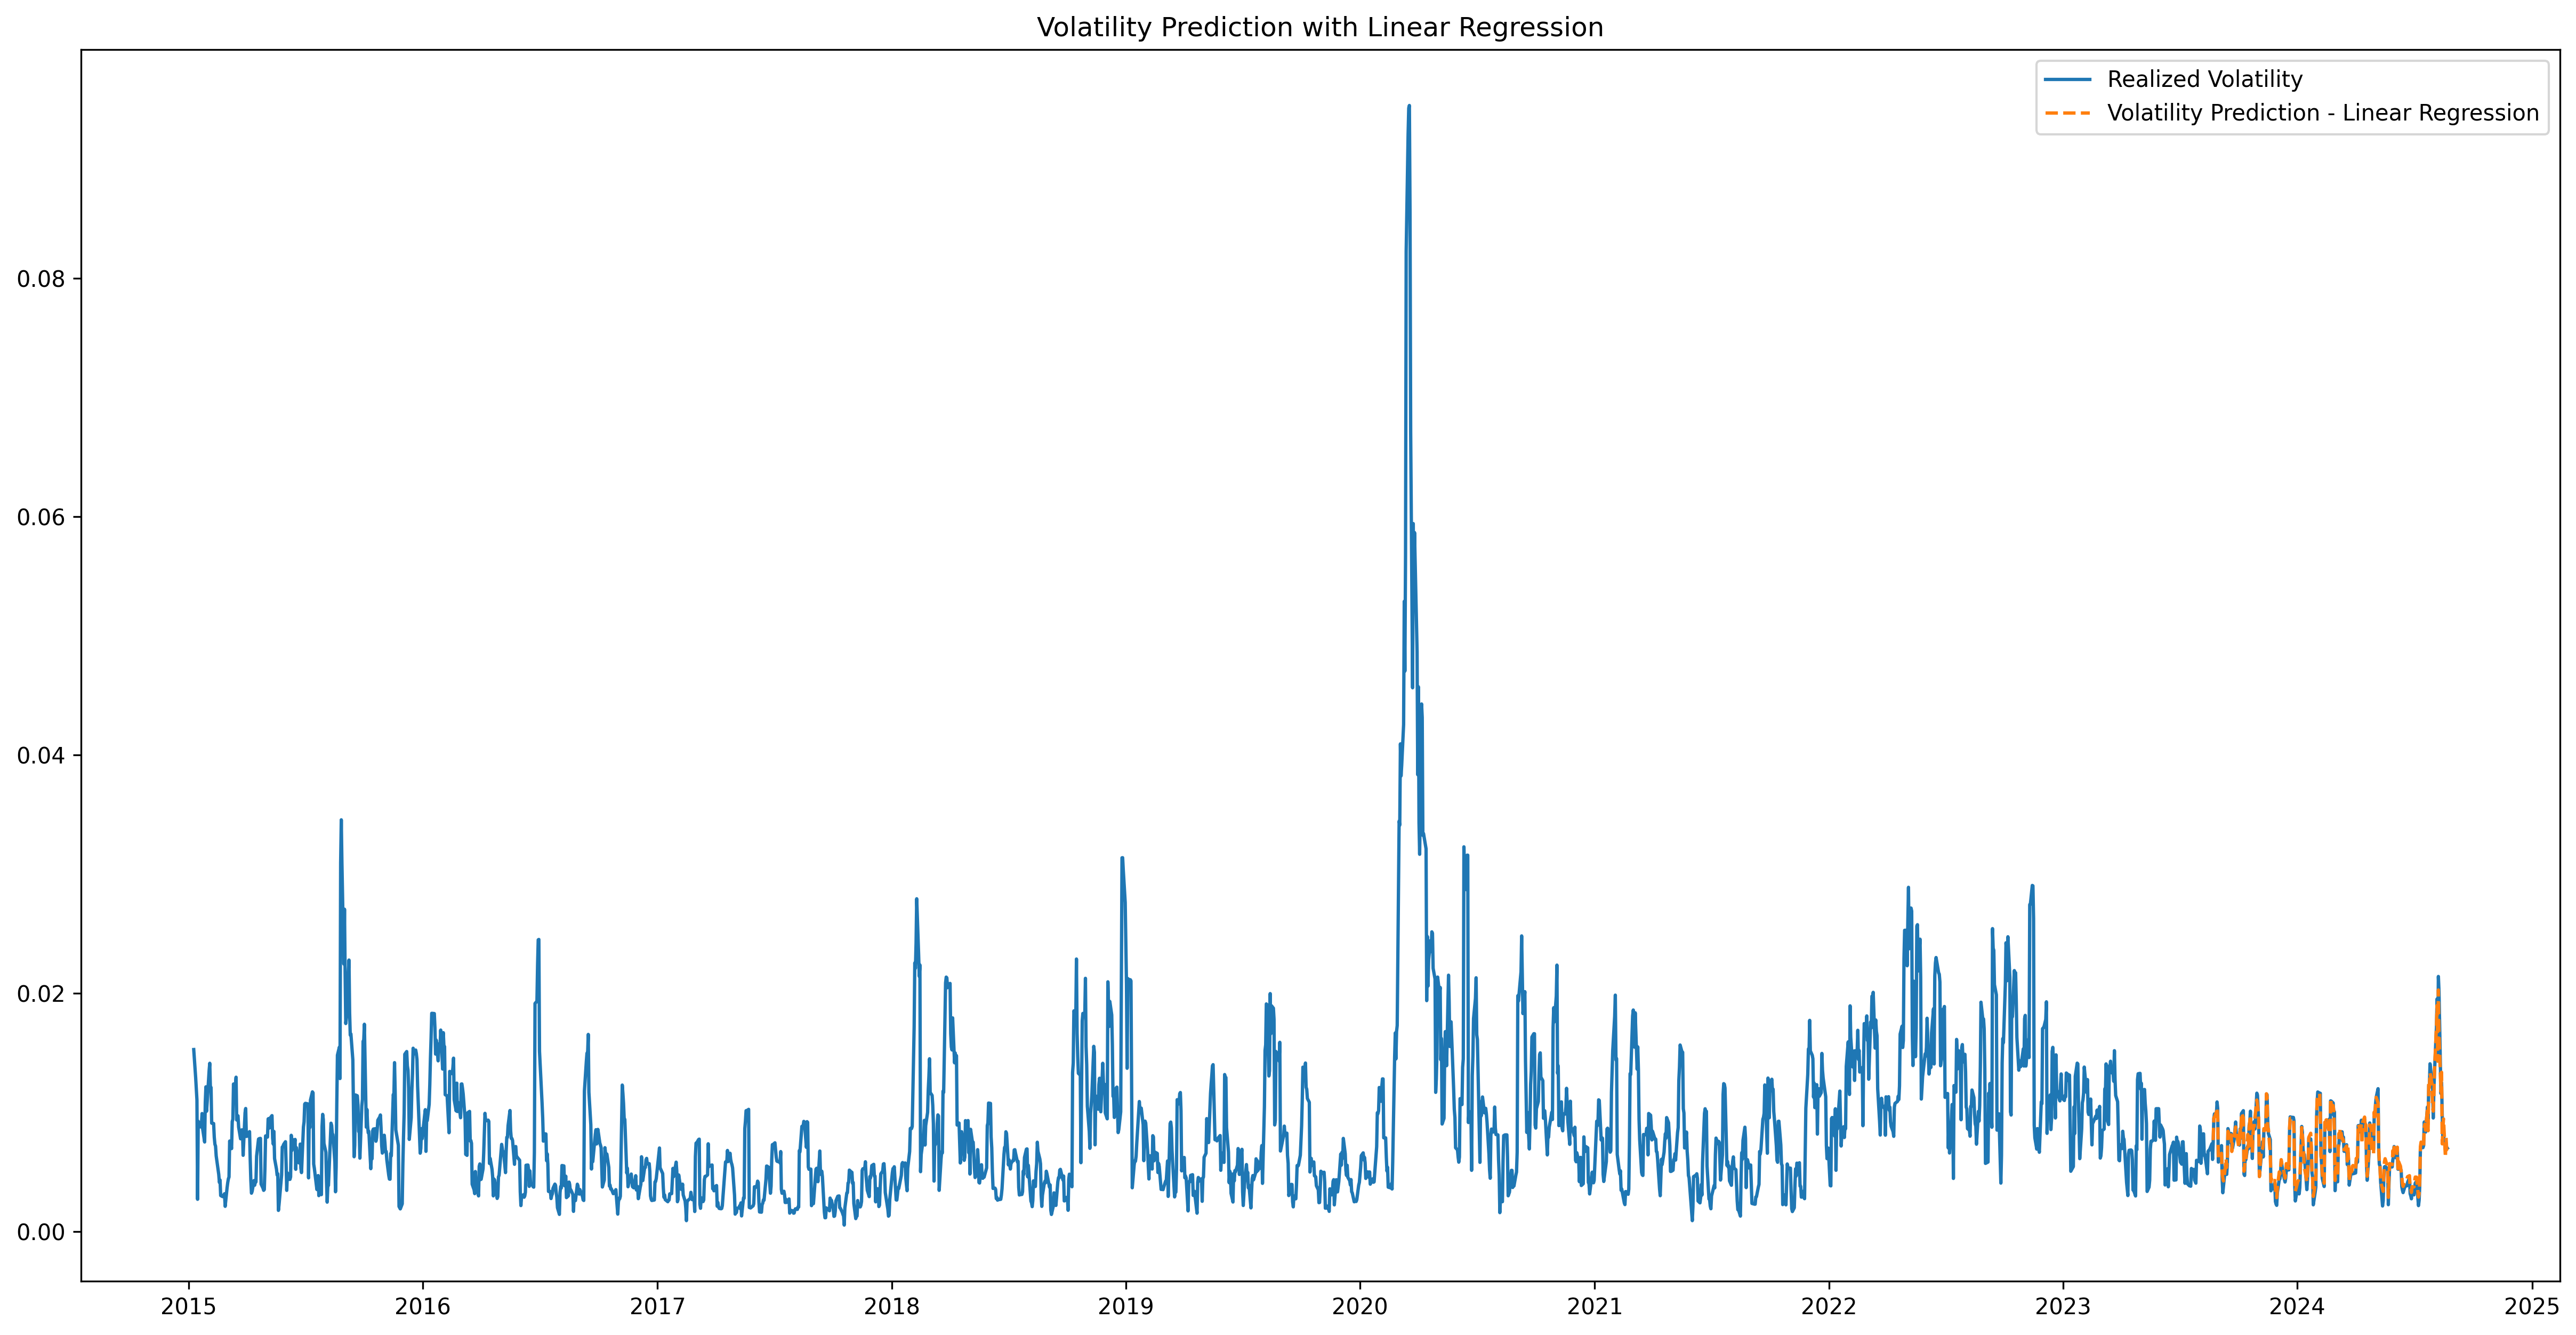

In [45]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(predict_lin_reg / 100,
         label='Volatility Prediction - Linear Regression', linestyle='--')
plt.title('Volatility Prediction with Linear Regression', fontsize=12)
plt.legend()
plt.show()

#### Deep Learning

In [46]:
model = keras.Sequential()

# Add layers using model.add()
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mse', optimizer='rmsprop')

In [47]:
np.arange(100, 400, 4)

array([100, 104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148,
       152, 156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200,
       204, 208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252,
       256, 260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304,
       308, 312, 316, 320, 324, 328, 332, 336, 340, 344, 348, 352, 356,
       360, 364, 368, 372, 376, 380, 384, 388, 392, 396])

In [48]:
epochs_trial = np.arange(100, 1000, 10)
batch_trial = np.arange(100, 400, 10)
DL_pred = []
DL_RMSE = []
for i, j, k in zip(range(10), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values,
              realized_vol['realized_vol'].iloc[10:-(n-1)].values.reshape(-1,),
              batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol['realized_vol'].iloc[-n:] / 100,
                               DL_predict.flatten() / 100)))
    DL_pred.append(DL_predict)
    print('DL_RMSE_{}:{:.6f}'.format(i+1, DL_RMSE[i]))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
DL_RMSE_1:0.001475
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_2:0.001616
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_3:0.001818
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
DL_RMSE_4:0.001809
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_5:0.001903
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_6:0.001851
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_7:0.001863
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_8:0.001859
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
DL_RMSE_9:0.001824
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_10:0.001851


In [49]:
DL_predict = pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index = ret.iloc[-n:].index

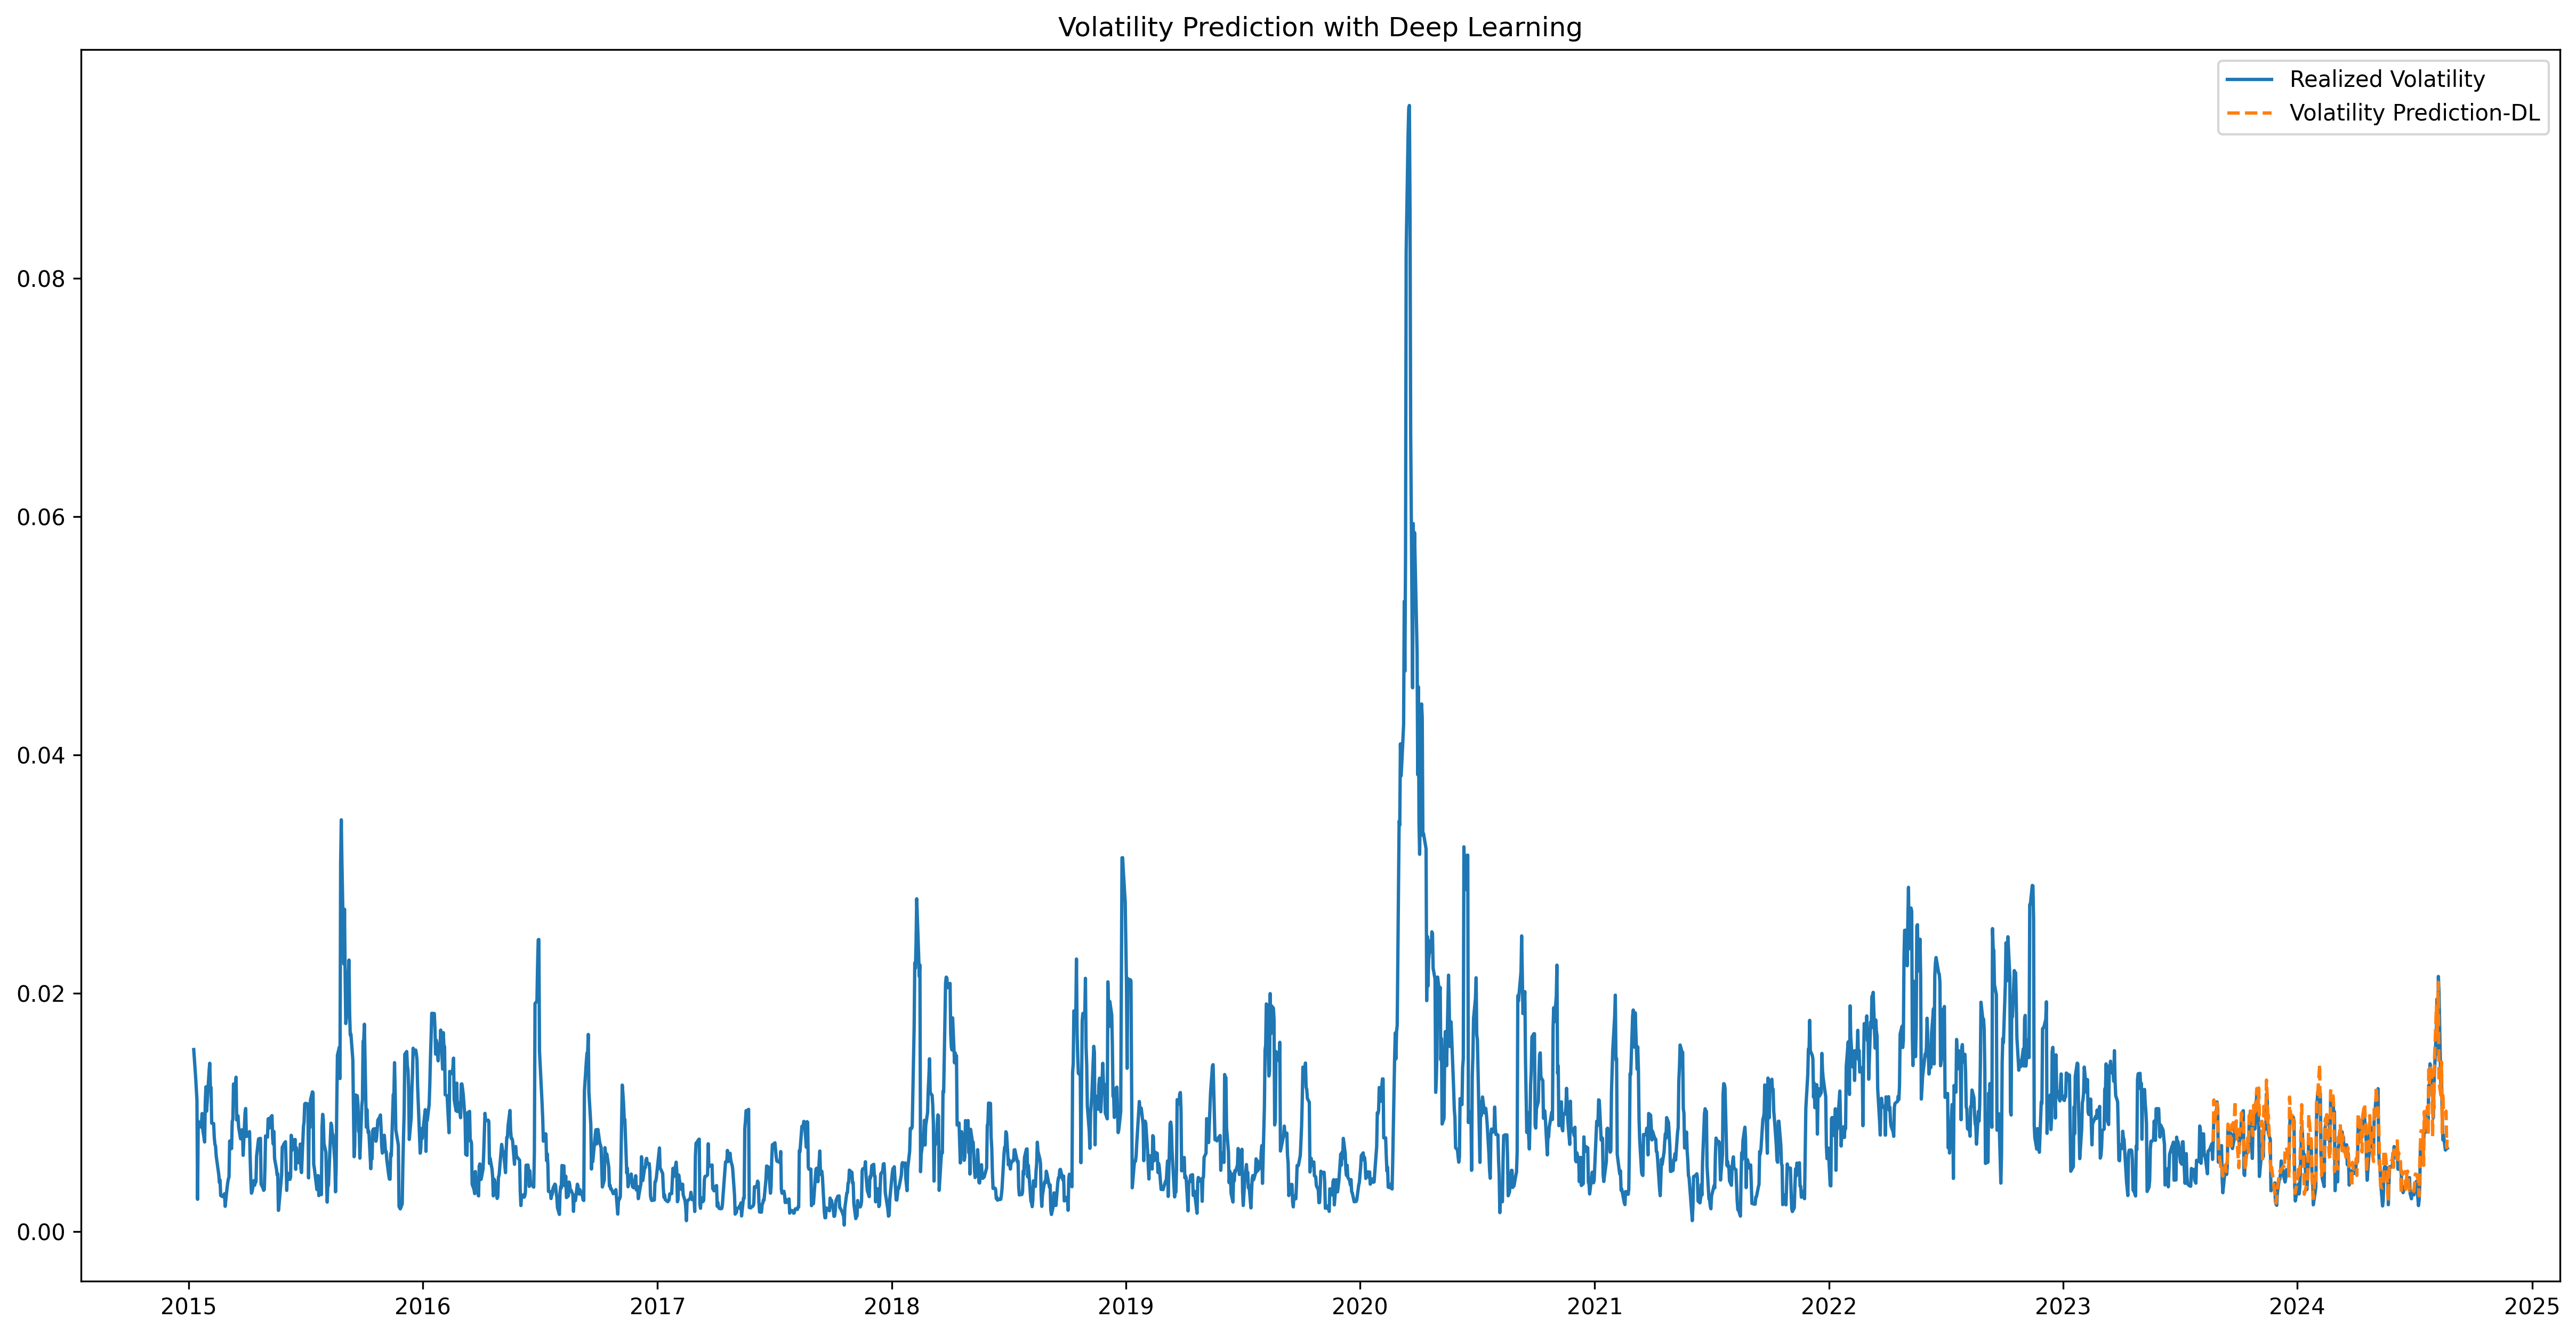

In [50]:
plt.figure(figsize=(20, 10))
plt.plot(realized_vol['realized_vol'] / 100, label='Realized Volatility')
plt.plot(DL_predict / 100, label='Volatility Prediction-DL', linestyle='--')
plt.title('Volatility Prediction with Deep Learning',  fontsize=12)
plt.legend()
plt.show()

### Summary

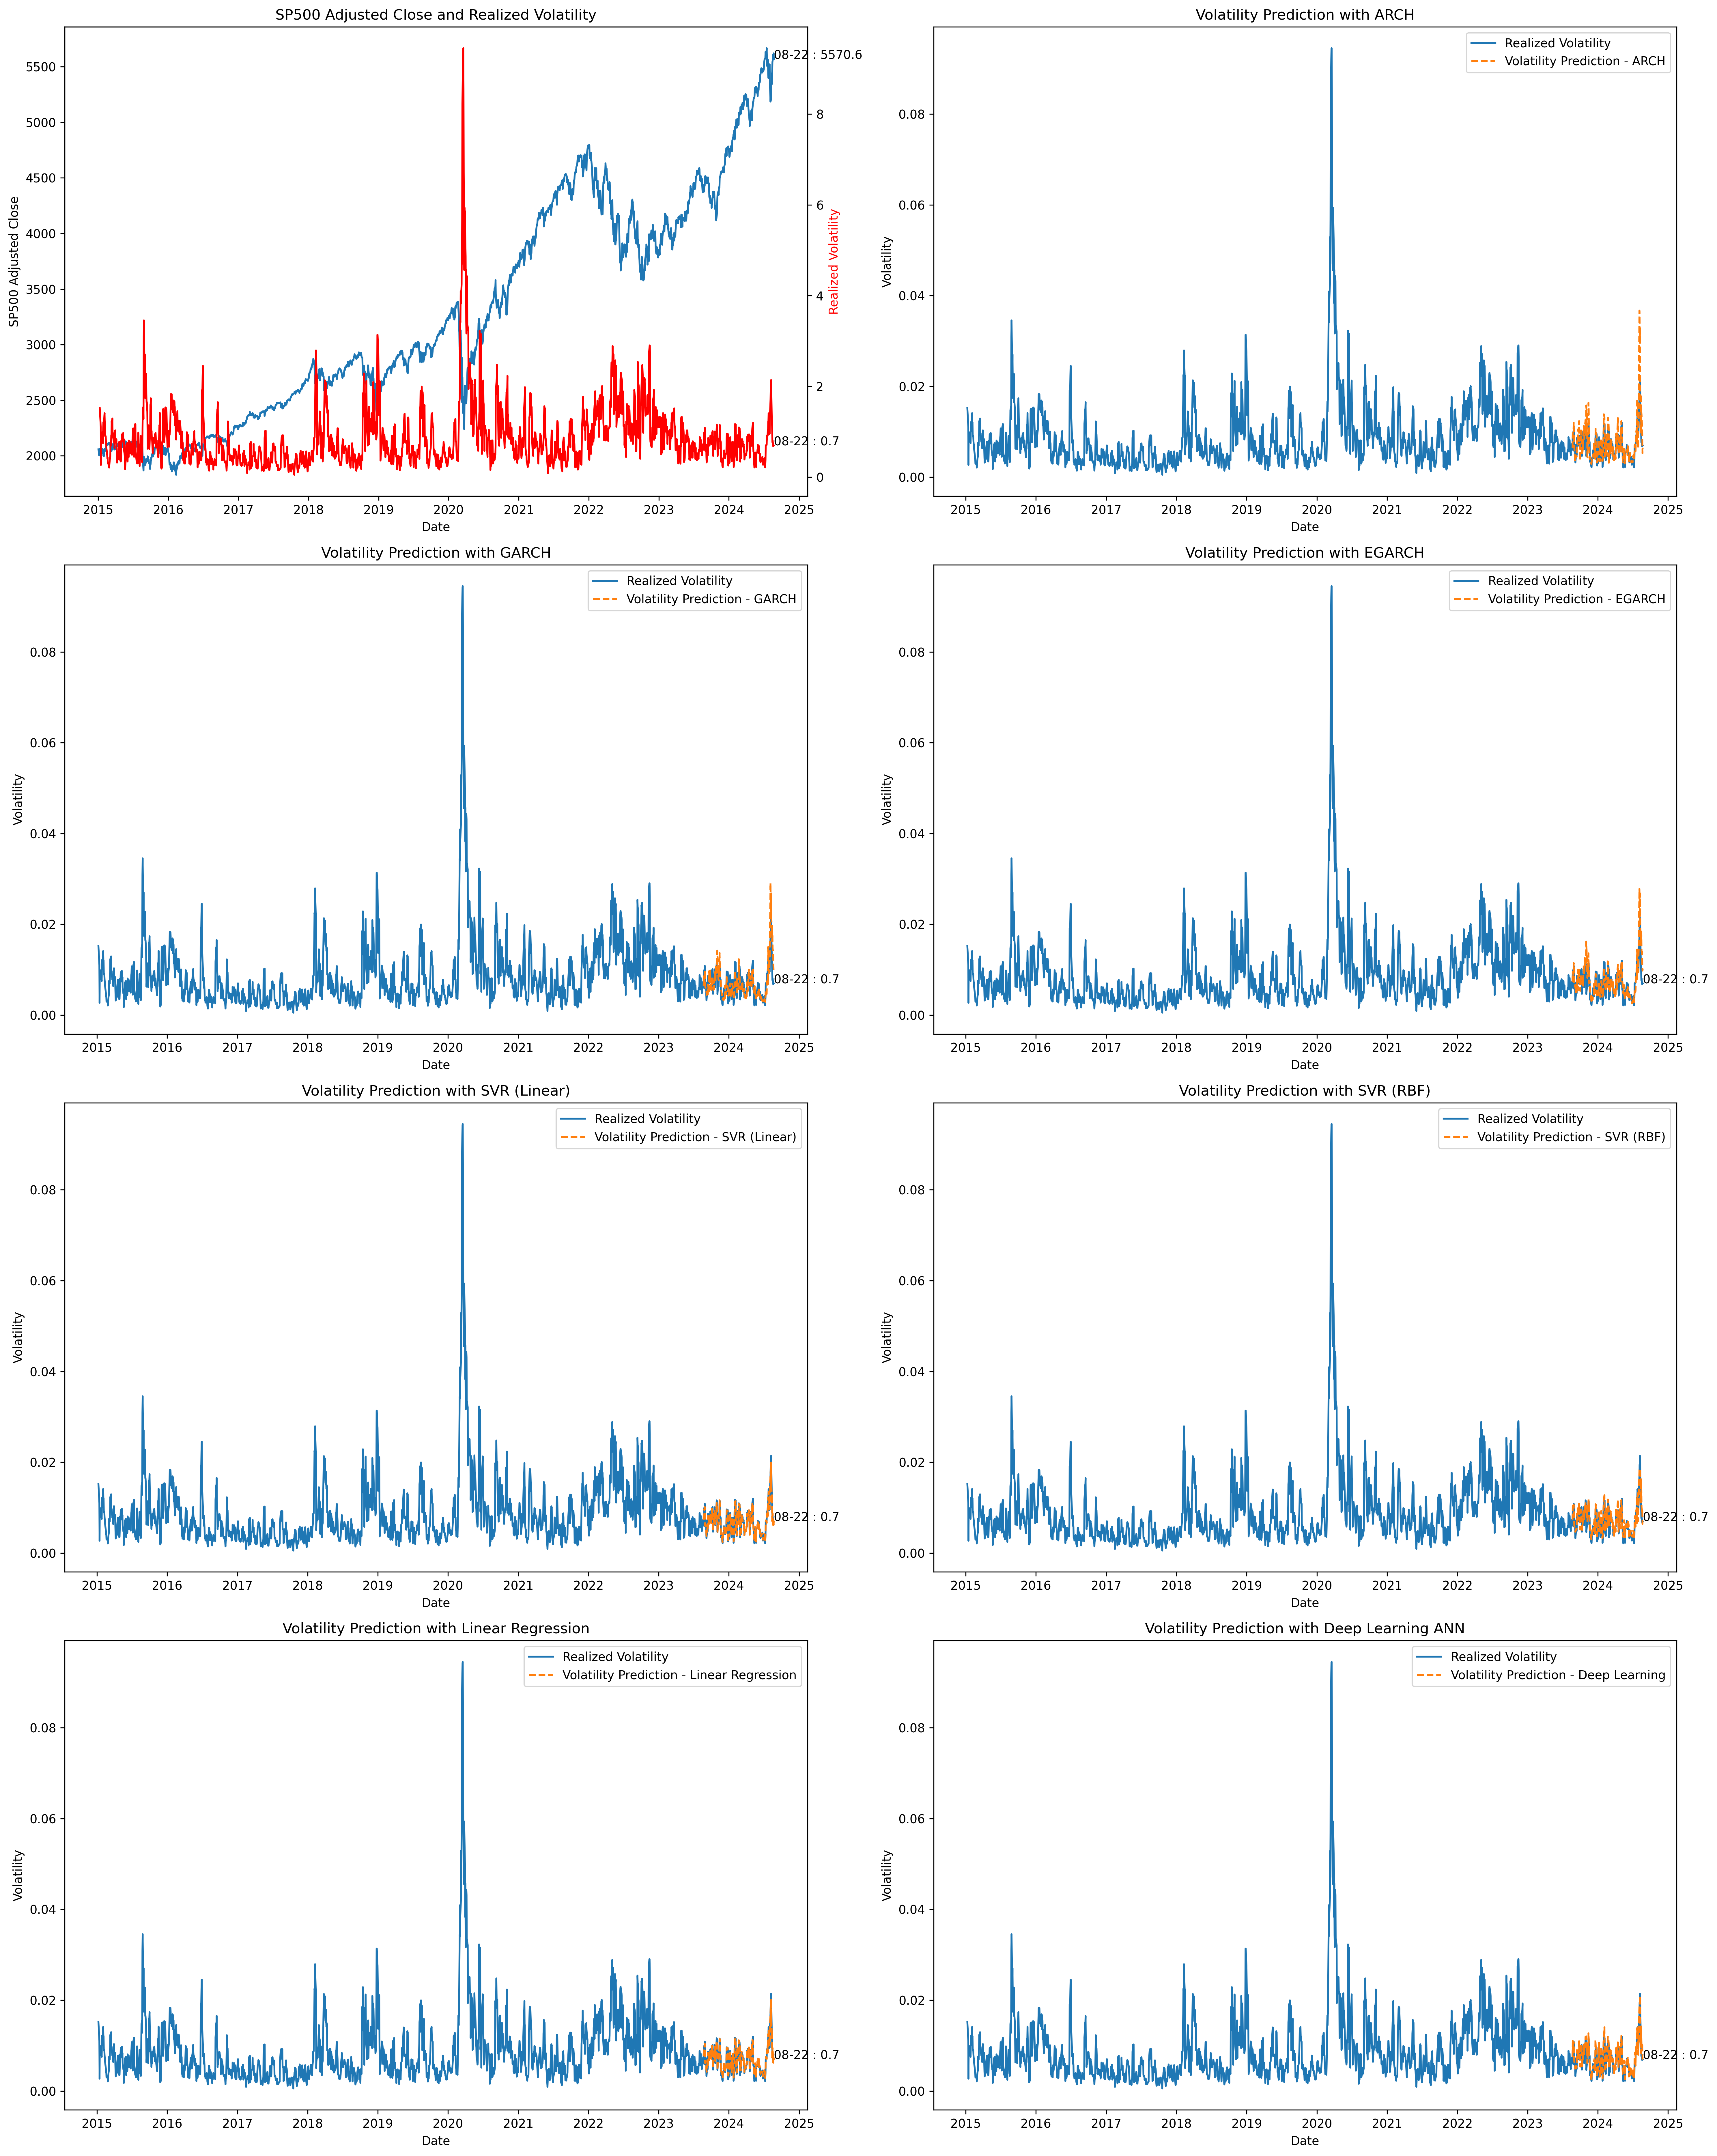

In [51]:
# Define the number of subplots
fig, axs = plt.subplots(4, 2, figsize=(20, 25))  # Adjusted to 5 rows

# Plot 1 and Plot 2 combined: SP500 Adjusted Close and Realized Volatility on the same plot with different y-axes
axs1 = axs[0, 0]
axs1.plot(s_p500['Adj Close'].index, s_p500['Adj Close'])
# Add text
axs1.text(s_p500['Adj Close'].index[-1], s_p500['Adj Close'][-1],
          f"{s_p500['Adj Close'].index[-1].strftime('%m-%d')} : {s_p500['Adj Close'][-1]:.1f}")

axs1.set_ylabel('SP500 Adjusted Close')
axs1.set_xlabel('Date')
axs1.set_title('SP500 Adjusted Close and Realized Volatility')

# Create a twin axis for realized volatility
axs2 = axs1.twinx()
axs2.plot(realized_vol.index, realized_vol['realized_vol'], color='red')
# Add text
axs2.text(realized_vol.index[-1], realized_vol['realized_vol'][-1],
          f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")
axs2.set_ylabel('Realized Volatility', color='red')

# ARCH Volatility Prediction
axs[0, 1].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
axs[0, 1].plot(forecast_arch.variance.iloc[-len(split_date):].index,
               forecast_arch.variance.iloc[-len(split_date):] / 100,
               label='Volatility Prediction - ARCH', linestyle='--')
axs[0, 1].set_title('Volatility Prediction with ARCH')
axs[0, 1].legend()
axs[0, 1].set_ylabel('Volatility')
axs[0, 1].set_xlabel('Date')

# GARCH Volatility Prediction
axs[1, 0].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
# Add text
axs[1, 0].text(realized_vol.index[-1], realized_vol['realized_vol'][-1]/100,
               f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")

axs[1, 0].plot(forecast_garch.variance.iloc[-len(split_date):].index,
               forecast_garch.variance.iloc[-len(split_date):] / 100,
               label='Volatility Prediction - GARCH', linestyle='--')

axs[1, 0].set_title('Volatility Prediction with GARCH')
axs[1, 0].legend()
axs[1, 0].set_ylabel('Volatility')
axs[1, 0].set_xlabel('Date')

# EGARCH Volatility Prediction
axs[1, 1].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
# Add text
axs[1, 1].text(realized_vol.index[-1], realized_vol['realized_vol'][-1]/100,
               f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")

axs[1, 1].plot(forecast_egarch.variance.iloc[-len(split_date):].index,
               forecast_egarch.variance.iloc[-len(split_date):] / 100,
               label='Volatility Prediction - EGARCH', linestyle='--')

axs[1, 1].set_title('Volatility Prediction with EGARCH')
axs[1, 1].legend()
axs[1, 1].set_ylabel('Volatility')
axs[1, 1].set_xlabel('Date')

# SVR (Linear Kernel)
axs[2, 0].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
# Add text
axs[2, 0].text(realized_vol.index[-1], realized_vol['realized_vol'][-1]/100,
               f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")

axs[2, 0].plot(predict_svr_lin.index, predict_svr_lin / 100,
               label='Volatility Prediction - SVR (Linear)', linestyle='--')
axs[2, 0].set_title('Volatility Prediction with SVR (Linear)')
axs[2, 0].legend()
axs[2, 0].set_ylabel('Volatility')
axs[2, 0].set_xlabel('Date')

# SVR (RBF Kernel)
axs[2, 1].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
# Add text
axs[2, 1].text(realized_vol.index[-1], realized_vol['realized_vol'][-1]/100,
               f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")

axs[2, 1].plot(predict_svr_rbf.index, predict_svr_rbf / 100,
               label='Volatility Prediction - SVR (RBF)', linestyle='--')
axs[2, 1].set_title('Volatility Prediction with SVR (RBF)')
axs[2, 1].legend()
axs[2, 1].set_ylabel('Volatility')
axs[2, 1].set_xlabel('Date')

# Linear Regression
axs[3, 0].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
# Add text
axs[3, 0].text(realized_vol.index[-1], realized_vol['realized_vol'][-1]/100,
               f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")
axs[3, 0].plot(predict_lin_reg.index, predict_lin_reg / 100,
               label='Volatility Prediction - Linear Regression', linestyle='--')
axs[3, 0].set_title('Volatility Prediction with Linear Regression')
axs[3, 0].legend()
axs[3, 0].set_ylabel('Volatility')
axs[3, 0].set_xlabel('Date')

# Deep Learning Volatility Prediction
axs[3, 1].plot(realized_vol.index, realized_vol['realized_vol'] /
               100, label='Realized Volatility')
# Add text
axs[3, 1].text(realized_vol.index[-1], realized_vol['realized_vol'][-1]/100,
               f"{realized_vol.index[-1].strftime('%m-%d')} : {realized_vol['realized_vol'][-1]:.1f}")
axs[3, 1].plot(DL_predict.index, DL_predict / 100,
               label='Volatility Prediction - Deep Learning', linestyle='--')
axs[3, 1].set_title('Volatility Prediction with Deep Learning ANN')
axs[3, 1].legend()
axs[3, 1].set_ylabel('Volatility')
axs[3, 1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Save the figure to a file
plt.savefig("volatility_predictions.png", dpi=200)

plt.show()